In [1]:
import pickle
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cdo
from scipy.spatial import KDTree

In [2]:
#defining function for RMSE

def rmse(obs, pred):
    actual_values = np.array(obs)
    predicted_values = np.array(pred)
    
    squared_errors = (obs - pred) ** 2
    
    mse = np.mean(squared_errors)
    
    rmse = np.sqrt(mse)
    
    return rmse


SYNOP are stations measurements, TEMP radiosondes and dropsondes, AIREP aircrafts, PILOT ballon observations, DRIBU are buoys
d[5,:] are my runs, d[0,:] Ariannas

## Global Verification 

In [161]:
#reading in data

urb_00_synop = xr.open_dataset('../verification_files/testurban_run2022061500SYNOP.nc')
urb_12_synop = xr.open_dataset('../verification_files/testurban_run2022061512SYNOP.nc')

opr_00_synop = xr.open_dataset('../verification_files/testoperational_run2022061500SYNOP.nc')
opr_12_synop = xr.open_dataset('../verification_files/testoperational_run2022061512SYNOP.nc')

urb_00_pilot = xr.open_dataset('../verification_files/testurban_run2022061500PILOT.nc')
urb_12_pilot = xr.open_dataset('../verification_files/testurban_run2022061512PILOT.nc')

opr_00_pilot = xr.open_dataset('../verification_files/testoperational_run2022061500PILOT.nc')
opr_12_pilot = xr.open_dataset('../verification_files/testoperational_run2022061512PILOT.nc')

urb_00_temp = xr.open_dataset('../verification_files/testurban_run2022061500TEMP.nc')
urb_12_temp = xr.open_dataset('../verification_files/testurban_run2022061512TEMP.nc')

opr_00_temp = xr.open_dataset('../verification_files/testoperational_run2022061500TEMP.nc')
opr_12_temp = xr.open_dataset('../verification_files/testoperational_run2022061512TEMP.nc')

urb_00_airep = xr.open_dataset('../verification_files/testurban_run2022061500AIREP.nc')
urb_12_airep = xr.open_dataset('../verification_files/testurban_run2022061512AIREP.nc')

opr_00_airep = xr.open_dataset('../verification_files/testoperational_run2022061500AIREP.nc')
opr_12_airep = xr.open_dataset('../verification_files/testoperational_run2022061512AIREP.nc')


In [424]:
files_399 = opr_12_synop.where(opr_12_synop.statid.str.contains('4104'), drop=True)

In [425]:
files_399.statid

<xarray.DataArray 'statid' (d_body: 2)>
array([b'04104     ', b'04104     '], dtype=object)
Coordinates:
    l_body    (d_body) float32 2.0 2.0
    obstype   (d_body) float32 1.0 1.0
    codetype  (d_body) float32 14.0 14.0
    ident     (d_body) float64 4.104e+03 4.104e+03
    lat       (d_body) float32 64.9 64.9
    lon       (d_body) float32 -23.93 -23.93
    varno     (d_body) float32 1.0 29.0
    level     (d_body) float32 1.002e+05 2.0
    state     (d_body) float32 0.0 0.0
    plevel    (d_body) float32 1.002e+05 9.962e+04
Dimensions without coordinates: d_body
Attributes:
    longname:  station id as character string

In [389]:
opr_12_airep.statid.where(opr_12_airep.statid == '00000399')

<xarray.DataArray 'statid' (d_body: 9303)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=object)
Coordinates:
    l_body    (d_body) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    obstype   (d_body) float32 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    codetype  (d_body) float32 141.0 141.0 141.0 141.0 ... 141.0 141.0 141.0
    ident     (d_body) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lat       (d_body) float32 18.87 18.87 16.92 16.92 ... 4.233 3.967 3.967
    lon       (d_body) float32 63.83 63.83 66.92 66.92 ... -137.9 -138.0 -138.0
    varno     (d_body) float32 3.0 4.0 3.0 4.0 3.0 4.0 ... 4.0 3.0 4.0 3.0 4.0
    level     (d_body) float32 1.968e+04 1.968e+04 ... 2.075e+04 2.075e+04
    state     (d_body) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    plevel    (d_body) float32 1.968e+04 1.968e+04 ... 2.075e+04 2.075e+04
Dimensions without coordinates: d_body
Attributes:
    longname:  station id as character string

In [7]:
opr_12_temp.veri_description.values

array([b'first guess                                                     ',
       b'first guess error                                               ',
       b'analysis in observation space                                   ',
       b'3dvar analysis                                                  ',
       b'VQC weight                                                      ',
       b'forecast vv= 1200                                               '],
      dtype='|S64')

In [8]:
#bug check, see if files are different from each other

urb_00_synop_modified = urb_00_synop.copy()
opr_00_synop_modified = opr_00_synop.copy()

urb_00_synop_modified.attrs.pop('history', None)
opr_00_synop_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_00_synop_modified, opr_00_synop_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.95 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 0.841 -7.325 ... 57.93 0.8013
    longname: modelled quantity (as indicated by veri_ens_member)


In [9]:
#same bug check

urb_12_pilot_modified = urb_12_pilot.copy()
opr_12_pilot_modified = opr_12_pilot.copy()

urb_12_pilot_modified.attrs.pop('history', None)
opr_12_pilot_modified.attrs.pop('history', None)

xr.testing.assert_identical(urb_12_pilot_modified, opr_12_pilot_modified)
print('The datasets are equal, excluding history')

AssertionError: Left and right Dataset objects are not identical


Differing data variables:
L   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.49 4.289
    longname: modelled quantity (as indicated by veri_ens_member)
R   veri_data         (d_veri, d_body) float32 -2.984 0.9247 ... 24.6 4.298
    longname: modelled quantity (as indicated by veri_ens_member)


## Global Verification

In [10]:
#set the style

sns.set_style('whitegrid')

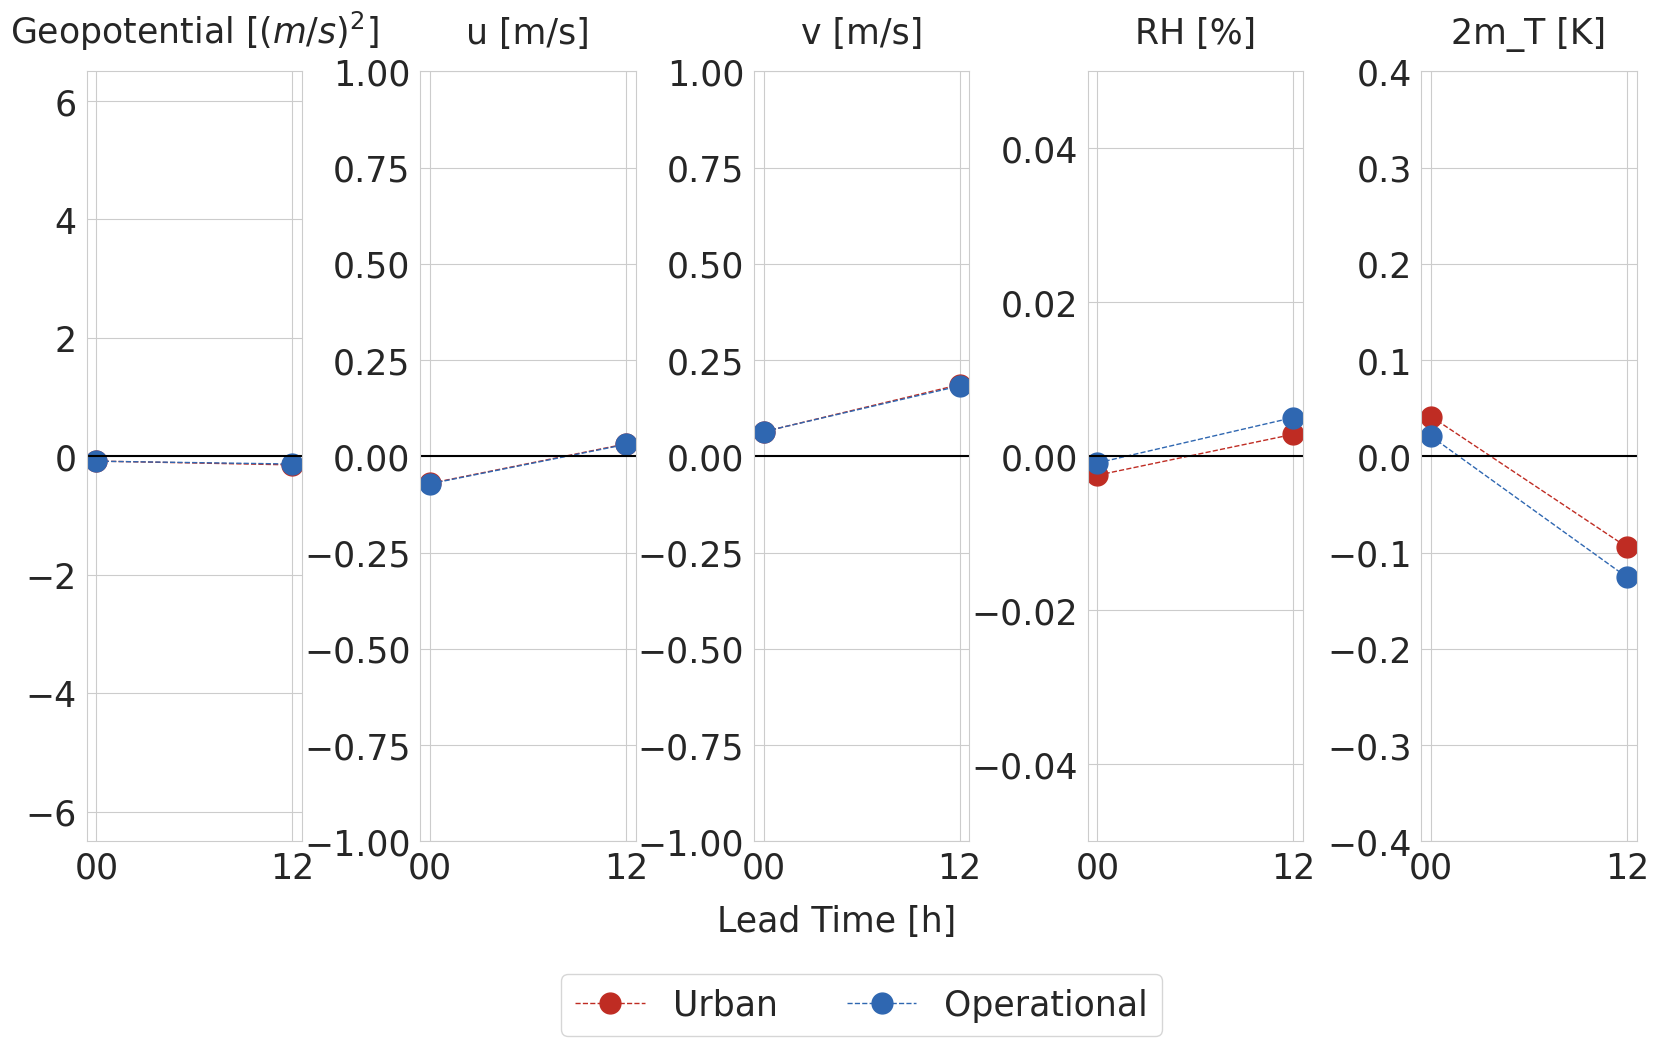

In [131]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']
#y_label = ['(m/s)**2 ', 'm/s', 'm/s', '%','K']

xlim_start = [-6.5, -1, -1, -.05, -.4]
xlim_end = [6.5, 1, 1, .05, .4]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10))

dataset = {
    'operational_00h': opr_00_synop,
    'urban_00h': urb_00_synop,
    'operational_12h': opr_12_synop,
    'urban_12h': urb_12_synop,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15,  color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')

    ax[i].set_title(varno[i], pad = 20)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2.6, -0.15), ncol=2)

for i, x_value in enumerate(x):
    ax[i].set_ylim(xlim_start[i], xlim_end[i])

fig.text(0.5, 0.02, 'Lead Time [h]', ha='center', fontsize=25)
fig.subplots_adjust(wspace=0.55) 

plt.savefig('../plots_2024/verification/verification_global_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')
#plt.tight_layout()
plt.show()


### RMSE calculations

In [254]:
np.unique(urb_12_synop.varno)

array([ 1.,  3.,  4., 29., 39.], dtype=float32)

In [307]:
#Geopot 00

rmse_synop_00_geopot_opr = rmse(opr_00_synop.obs.where(opr_00_synop.varno == 1), opr_00_synop.veri_data[6,:].where(opr_00_synop.varno == 1))
rmse_synop_00_geopot_urb = rmse(urb_00_synop.obs.where(urb_00_synop.varno == 1), urb_00_synop.veri_data[6,:].where(urb_00_synop.varno == 1))
print(np.round(rmse_synop_00_geopot_opr,4))
print(np.round(rmse_synop_00_geopot_urb,4))
print(np.round((1 - rmse_synop_00_geopot_urb/rmse_synop_00_geopot_opr) * 100,2))

<xarray.DataArray ()>
array(17.6241, dtype=float32)
<xarray.DataArray ()>
array(17.624, dtype=float32)
<xarray.DataArray ()>
array(0.)


In [308]:
#Geopot 00 cities

rmse_synop_00_geopot_opr_cities = rmse(opr_00_synop_cities.obs.where(opr_00_synop_cities.varno == 1), opr_00_synop_cities.veri_data[6,:].where(opr_00_synop_cities.varno == 1))
rmse_synop_00_geopot_urb_cities = rmse(urb_00_synop_cities.obs.where(urb_00_synop_cities.varno == 1), urb_00_synop_cities.veri_data[6,:].where(urb_00_synop_cities.varno == 1))
print(np.round(rmse_synop_00_geopot_opr_cities,4))
print(np.round(rmse_synop_00_geopot_urb_cities,4))
print(np.round((1 - rmse_synop_00_geopot_urb_cities/rmse_synop_00_geopot_opr_cities) * 100,2))

<xarray.DataArray ()>
array(37.7376, dtype=float32)
<xarray.DataArray ()>
array(37.7513, dtype=float32)
<xarray.DataArray ()>
array(-0.04)


In [309]:
#Geopot 12

rmse_synop_12_geopot_opr = rmse(opr_12_synop.obs.where(opr_12_synop.varno == 1), opr_12_synop.veri_data[5,:].where(opr_12_synop.varno == 1),)
rmse_synop_12_geopot_urb = rmse(urb_12_synop.obs.where(urb_12_synop.varno == 1),urb_12_synop.veri_data[5,:].where(urb_12_synop.varno == 1))
print(np.round(rmse_synop_12_geopot_opr,4))
print(np.round(rmse_synop_12_geopot_urb,4))
print(np.round((1 - rmse_synop_12_geopot_urb/rmse_synop_12_geopot_opr) * 100,2))

<xarray.DataArray ()>
array(22.0036, dtype=float32)
<xarray.DataArray ()>
array(22.0054, dtype=float32)
<xarray.DataArray ()>
array(-0.01)


In [310]:
#Geopot 12 cities

rmse_synop_12_geopot_opr_cities = rmse(opr_12_synop_cities.obs.where(opr_12_synop_cities.varno == 1), opr_12_synop_cities.veri_data[5,:].where(opr_12_synop_cities.varno == 1))
rmse_synop_12_geopot_urb_cities = rmse(urb_12_synop_cities.obs.where(urb_12_synop_cities.varno == 1), urb_12_synop_cities.veri_data[5,:].where(urb_12_synop_cities.varno == 1))
print(np.round(rmse_synop_12_geopot_opr_cities,4))
print(np.round(rmse_synop_12_geopot_urb_cities,4))
print(np.round((1 - rmse_synop_12_geopot_urb_cities/rmse_synop_12_geopot_opr_cities) * 100,2))

<xarray.DataArray ()>
array(21.4443, dtype=float32)
<xarray.DataArray ()>
array(21.533, dtype=float32)
<xarray.DataArray ()>
array(-0.41)


In [311]:
#u 00

rmse_synop_00_u_opr = rmse(opr_00_synop.obs.where(opr_00_synop.varno == 3), opr_00_synop.veri_data[6,:].where(opr_00_synop.varno == 3))
rmse_synop_00_u_urb = rmse(urb_00_synop.obs.where(urb_00_synop.varno == 3), urb_00_synop.veri_data[6,:].where(urb_00_synop.varno == 3))
print(np.round(rmse_synop_00_u_opr,4))
print(np.round(rmse_synop_00_u_urb,4))
print(np.round((1 - rmse_synop_00_u_urb/rmse_synop_00_u_opr) * 100,2))

<xarray.DataArray ()>
array(1.5791, dtype=float32)
<xarray.DataArray ()>
array(1.5794, dtype=float32)
<xarray.DataArray ()>
array(-0.02)


In [312]:
#u 00 cities

rmse_synop_00_u_opr_cities = rmse(opr_00_synop_cities.obs.where(opr_00_synop_cities.varno == 3), opr_00_synop_cities.veri_data[6,:].where(opr_00_synop_cities.varno == 3))
rmse_synop_00_u_urb_cities = rmse(urb_00_synop_cities.obs.where(urb_00_synop_cities.varno == 3), urb_00_synop_cities.veri_data[6,:].where(urb_00_synop_cities.varno == 3))
print(np.round(rmse_synop_00_u_opr_cities,4))
print(np.round(rmse_synop_00_u_urb_cities,4))
print(np.round((1 - rmse_synop_00_u_urb_cities/rmse_synop_00_u_opr_cities) * 100,2))

<xarray.DataArray ()>
array(1.3979, dtype=float32)
<xarray.DataArray ()>
array(1.4247, dtype=float32)
<xarray.DataArray ()>
array(-1.92)


In [313]:
#u 12

rmse_synop_12_u_opr = rmse(opr_12_synop.obs.where(opr_12_synop.varno == 3), opr_12_synop.veri_data[5,:].where(opr_12_synop.varno == 3))
rmse_synop_12_u_urb = rmse(urb_12_synop.obs.where(urb_12_synop.varno == 3), urb_12_synop.veri_data[5,:].where(urb_12_synop.varno == 3),)
print(np.round(rmse_synop_12_u_opr,4))
print(np.round(rmse_synop_12_u_urb,4))
print(np.round((1 - rmse_synop_12_u_urb/rmse_synop_12_u_opr) * 100,2))

<xarray.DataArray ()>
array(2.0362, dtype=float32)
<xarray.DataArray ()>
array(2.0384, dtype=float32)
<xarray.DataArray ()>
array(-0.11)


In [314]:
#u 12 cities

rmse_synop_12_u_opr_cities = rmse(opr_12_synop_cities .obs.where(opr_12_synop_cities .varno == 3), opr_12_synop_cities .veri_data[5,:].where(opr_12_synop_cities .varno == 3))
rmse_synop_12_u_urb_cities  = rmse(urb_12_synop_cities .obs.where(urb_12_synop_cities .varno == 3), urb_12_synop_cities .veri_data[5,:].where(urb_12_synop_cities .varno == 3))
print(np.round(rmse_synop_12_u_opr_cities ,4))
print(np.round(rmse_synop_12_u_urb_cities ,4))
print(np.round((1 - rmse_synop_12_u_urb_cities /rmse_synop_12_u_opr_cities ) * 100,2))

<xarray.DataArray ()>
array(2.8006, dtype=float32)
<xarray.DataArray ()>
array(2.8455, dtype=float32)
<xarray.DataArray ()>
array(-1.61)


In [315]:
#v 00

rmse_synop_00_v_opr = rmse(opr_00_synop.obs.where(opr_00_synop.varno == 4), opr_00_synop.veri_data[6,:].where(opr_00_synop.varno == 4),)
rmse_synop_00_v_urb = rmse(urb_00_synop.obs.where(urb_00_synop.varno == 4), urb_00_synop.veri_data[6,:].where(urb_00_synop.varno == 4))
print(np.round(rmse_synop_00_v_opr,4))
print(np.round(rmse_synop_00_v_urb,4))
print(np.round((1 - rmse_synop_00_v_urb/rmse_synop_00_v_opr) * 100,2))

<xarray.DataArray ()>
array(1.5788, dtype=float32)
<xarray.DataArray ()>
array(1.579, dtype=float32)
<xarray.DataArray ()>
array(-0.02)


In [320]:
#v 00 cities

rmse_synop_00_v_opr_cities = rmse(opr_00_synop_cities.obs.where(opr_00_synop_cities.varno == 4),opr_00_synop_cities.veri_data[6,:].where(opr_00_synop_cities.varno == 4))
rmse_synop_00_v_urb_cities = rmse(urb_00_synop_cities.obs.where(urb_00_synop_cities.varno == 4), urb_00_synop_cities.veri_data[6,:].where(urb_00_synop_cities.varno == 4))
print(np.round(rmse_synop_00_v_opr_cities,4))
print(np.round(rmse_synop_00_v_urb_cities,4))
print(np.round((1 - rmse_synop_00_v_urb_cities/rmse_synop_00_v_opr_cities) * 100,2))

<xarray.DataArray ()>
array(1.4105, dtype=float32)
<xarray.DataArray ()>
array(1.4345, dtype=float32)
<xarray.DataArray ()>
array(-1.7)


In [321]:
#v 12

rmse_synop_12_v_opr = rmse(opr_12_synop.obs.where(opr_12_synop.varno == 4), opr_12_synop.veri_data[5,:].where(opr_12_synop.varno == 4))
rmse_synop_12_v_urb = rmse(urb_12_synop.obs.where(urb_12_synop.varno == 4), urb_12_synop.veri_data[5,:].where(urb_12_synop.varno == 4))
print(np.round(rmse_synop_12_v_opr,4))
print(np.round(rmse_synop_12_v_urb,4))
print(np.round((1 - rmse_synop_12_v_urb/rmse_synop_12_v_opr) * 100,2))

<xarray.DataArray ()>
array(1.986, dtype=float32)
<xarray.DataArray ()>
array(1.9869, dtype=float32)
<xarray.DataArray ()>
array(-0.04)


In [322]:
#v 12 cities

rmse_synop_12_v_opr_cities = rmse(opr_12_synop_cities.obs.where(opr_12_synop_cities.varno == 4), opr_12_synop_cities.veri_data[5,:].where(opr_12_synop_cities.varno == 4))
rmse_synop_12_v_urb_cities = rmse(urb_12_synop_cities.obs.where(urb_12_synop_cities.varno == 4), urb_12_synop_cities.veri_data[5,:].where(urb_12_synop_cities.varno == 4))
print(np.round(rmse_synop_12_v_opr_cities,4))
print(np.round(rmse_synop_12_v_urb_cities,4))
print(np.round((1 - rmse_synop_12_v_urb_cities/rmse_synop_12_v_opr_cities) * 100,2))

<xarray.DataArray ()>
array(1.0469, dtype=float32)
<xarray.DataArray ()>
array(1.1183, dtype=float32)
<xarray.DataArray ()>
array(-6.82)


In [323]:
#RH 00

rmse_synop_00_RH_opr = rmse(opr_00_synop.obs.where(opr_00_synop.varno == 29), opr_00_synop.veri_data[6,:].where(opr_00_synop.varno == 29))
rmse_synop_00_RH_urb = rmse(urb_00_synop.obs.where(urb_00_synop.varno == 29), urb_00_synop.veri_data[6,:].where(urb_00_synop.varno == 29))
print(np.round(rmse_synop_00_RH_opr,4))
print(np.round(rmse_synop_00_RH_urb,4))
print(np.round((1 - rmse_synop_00_RH_urb/rmse_synop_00_RH_opr) * 100,2))

<xarray.DataArray ()>
array(0.0843, dtype=float32)
<xarray.DataArray ()>
array(0.0841, dtype=float32)
<xarray.DataArray ()>
array(0.22)


In [324]:
#RH 00 cities

rmse_synop_00_RH_opr_cities = rmse(opr_00_synop_cities.obs.where(opr_00_synop_cities.varno == 29), opr_00_synop_cities.veri_data[6,:].where(opr_00_synop_cities.varno == 29))
rmse_synop_00_RH_urb_cities = rmse(urb_00_synop_cities.obs.where(urb_00_synop_cities.varno == 29), urb_00_synop_cities.veri_data[6,:].where(urb_00_synop_cities.varno == 29))
print(np.round(rmse_synop_00_RH_opr_cities,4))
print(np.round(rmse_synop_00_RH_urb_cities,4))
print(np.round((1 - rmse_synop_00_RH_urb_cities/rmse_synop_00_RH_opr_cities) * 100,2))

<xarray.DataArray ()>
array(0.0769, dtype=float32)
<xarray.DataArray ()>
array(0.0718, dtype=float32)
<xarray.DataArray ()>
array(6.68)


In [325]:
#RH 12

rmse_synop_12_RH_opr = rmse(opr_12_synop.obs.where(opr_12_synop.varno == 29), opr_12_synop.veri_data[5,:].where(opr_12_synop.varno == 29))
rmse_synop_12_RH_urb = rmse(urb_12_synop.obs.where(urb_12_synop.varno == 29), urb_12_synop.veri_data[5,:].where(urb_12_synop.varno == 29))
print(np.round(rmse_synop_12_RH_opr,4))
print(np.round(rmse_synop_12_RH_urb,4))
print(np.round((1 - rmse_synop_12_RH_urb/rmse_synop_12_RH_opr) * 100,2))

<xarray.DataArray ()>
array(0.0937, dtype=float32)
<xarray.DataArray ()>
array(0.094, dtype=float32)
<xarray.DataArray ()>
array(-0.28)


In [326]:
#RH 12 cities

rmse_synop_12_RH_opr_cities = rmse(opr_12_synop_cities.obs.where(opr_12_synop_cities.varno == 29), opr_12_synop_cities.veri_data[5,:].where(opr_12_synop_cities.varno == 29))
rmse_synop_12_RH_urb_cities = rmse(urb_12_synop_cities.obs.where(urb_12_synop_cities.varno == 29),urb_12_synop_cities.veri_data[5,:].where(urb_12_synop_cities.varno == 29))
print(np.round(rmse_synop_12_RH_opr_cities,4))
print(np.round(rmse_synop_12_RH_urb_cities,4))
print(np.round((1 - rmse_synop_12_RH_urb_cities/rmse_synop_12_RH_opr_cities) * 100,2))

<xarray.DataArray ()>
array(0.0933, dtype=float32)
<xarray.DataArray ()>
array(0.1022, dtype=float32)
<xarray.DataArray ()>
array(-9.52)


In [327]:
#2mT 00

rmse_synop_00_2mT_opr = rmse(opr_00_synop.obs.where(opr_00_synop.varno == 39), opr_00_synop.veri_data[6,:].where(opr_00_synop.varno == 39))
rmse_synop_00_2mT_urb = rmse(urb_00_synop.obs.where(urb_00_synop.varno == 39), urb_00_synop.veri_data[6,:].where(urb_00_synop.varno == 39))
print(np.round(rmse_synop_00_2mT_opr,4))
print(np.round(rmse_synop_00_2mT_urb,4))
print(np.round((1 - rmse_synop_00_2mT_urb/rmse_synop_00_2mT_opr) * 100,2))

<xarray.DataArray ()>
array(1.4718, dtype=float32)
<xarray.DataArray ()>
array(1.4711, dtype=float32)
<xarray.DataArray ()>
array(0.05)


In [328]:
#2mT 00 cities

rmse_synop_00_2mT_opr_cities = rmse(opr_00_synop_cities .obs.where(opr_00_synop_cities .varno == 39), opr_00_synop_cities .veri_data[6,:].where(opr_00_synop_cities .varno == 39))
rmse_synop_00_2mT_urb_cities  = rmse(urb_00_synop_cities .obs.where(urb_00_synop_cities .varno == 39), urb_00_synop_cities .veri_data[6,:].where(urb_00_synop_cities .varno == 39),)
print(np.round(rmse_synop_00_2mT_opr_cities ,4))
print(np.round(rmse_synop_00_2mT_urb_cities ,4))
print(np.round((1 - rmse_synop_00_2mT_urb_cities /rmse_synop_00_2mT_opr_cities ) * 100,2))

<xarray.DataArray ()>
array(1.443, dtype=float32)
<xarray.DataArray ()>
array(1.5303, dtype=float32)
<xarray.DataArray ()>
array(-6.05)


In [329]:
#2mT 12

rmse_synop_12_2mT_opr = rmse(opr_12_synop.obs.where(opr_12_synop.varno == 39), opr_12_synop.veri_data[5,:].where(opr_12_synop.varno == 39))
rmse_synop_12_2mT_urb = rmse(urb_12_synop.obs.where(urb_12_synop.varno == 39), urb_12_synop.veri_data[5,:].where(urb_12_synop.varno == 39))
print(np.round(rmse_synop_12_2mT_opr,4))
print(np.round(rmse_synop_12_2mT_urb,4))
print(np.round((1 - rmse_synop_12_2mT_urb/rmse_synop_12_2mT_opr) * 100,2))

<xarray.DataArray ()>
array(1.5599, dtype=float32)
<xarray.DataArray ()>
array(1.5633, dtype=float32)
<xarray.DataArray ()>
array(-0.22)


In [331]:
#2mT 12 cities

rmse_synop_12_2mT_opr_cities = rmse(opr_12_synop_cities.obs.where(opr_12_synop_cities.varno == 39), opr_12_synop_cities.veri_data[5,:].where(opr_12_synop_cities.varno == 39))
rmse_synop_12_2mT_urb_cities = rmse(urb_12_synop_cities.obs.where(urb_12_synop_cities.varno == 39), urb_12_synop_cities.veri_data[5,:].where(urb_12_synop_cities.varno == 39))
print(np.round(rmse_synop_12_2mT_opr_cities,4))
print(np.round(rmse_synop_12_2mT_urb_cities,4))
print(np.round((1 - rmse_synop_12_2mT_urb_cities/rmse_synop_12_2mT_opr_cities) * 100,2))

<xarray.DataArray ()>
array(1.8465, dtype=float32)
<xarray.DataArray ()>
array(1.8336, dtype=float32)
<xarray.DataArray ()>
array(0.7)


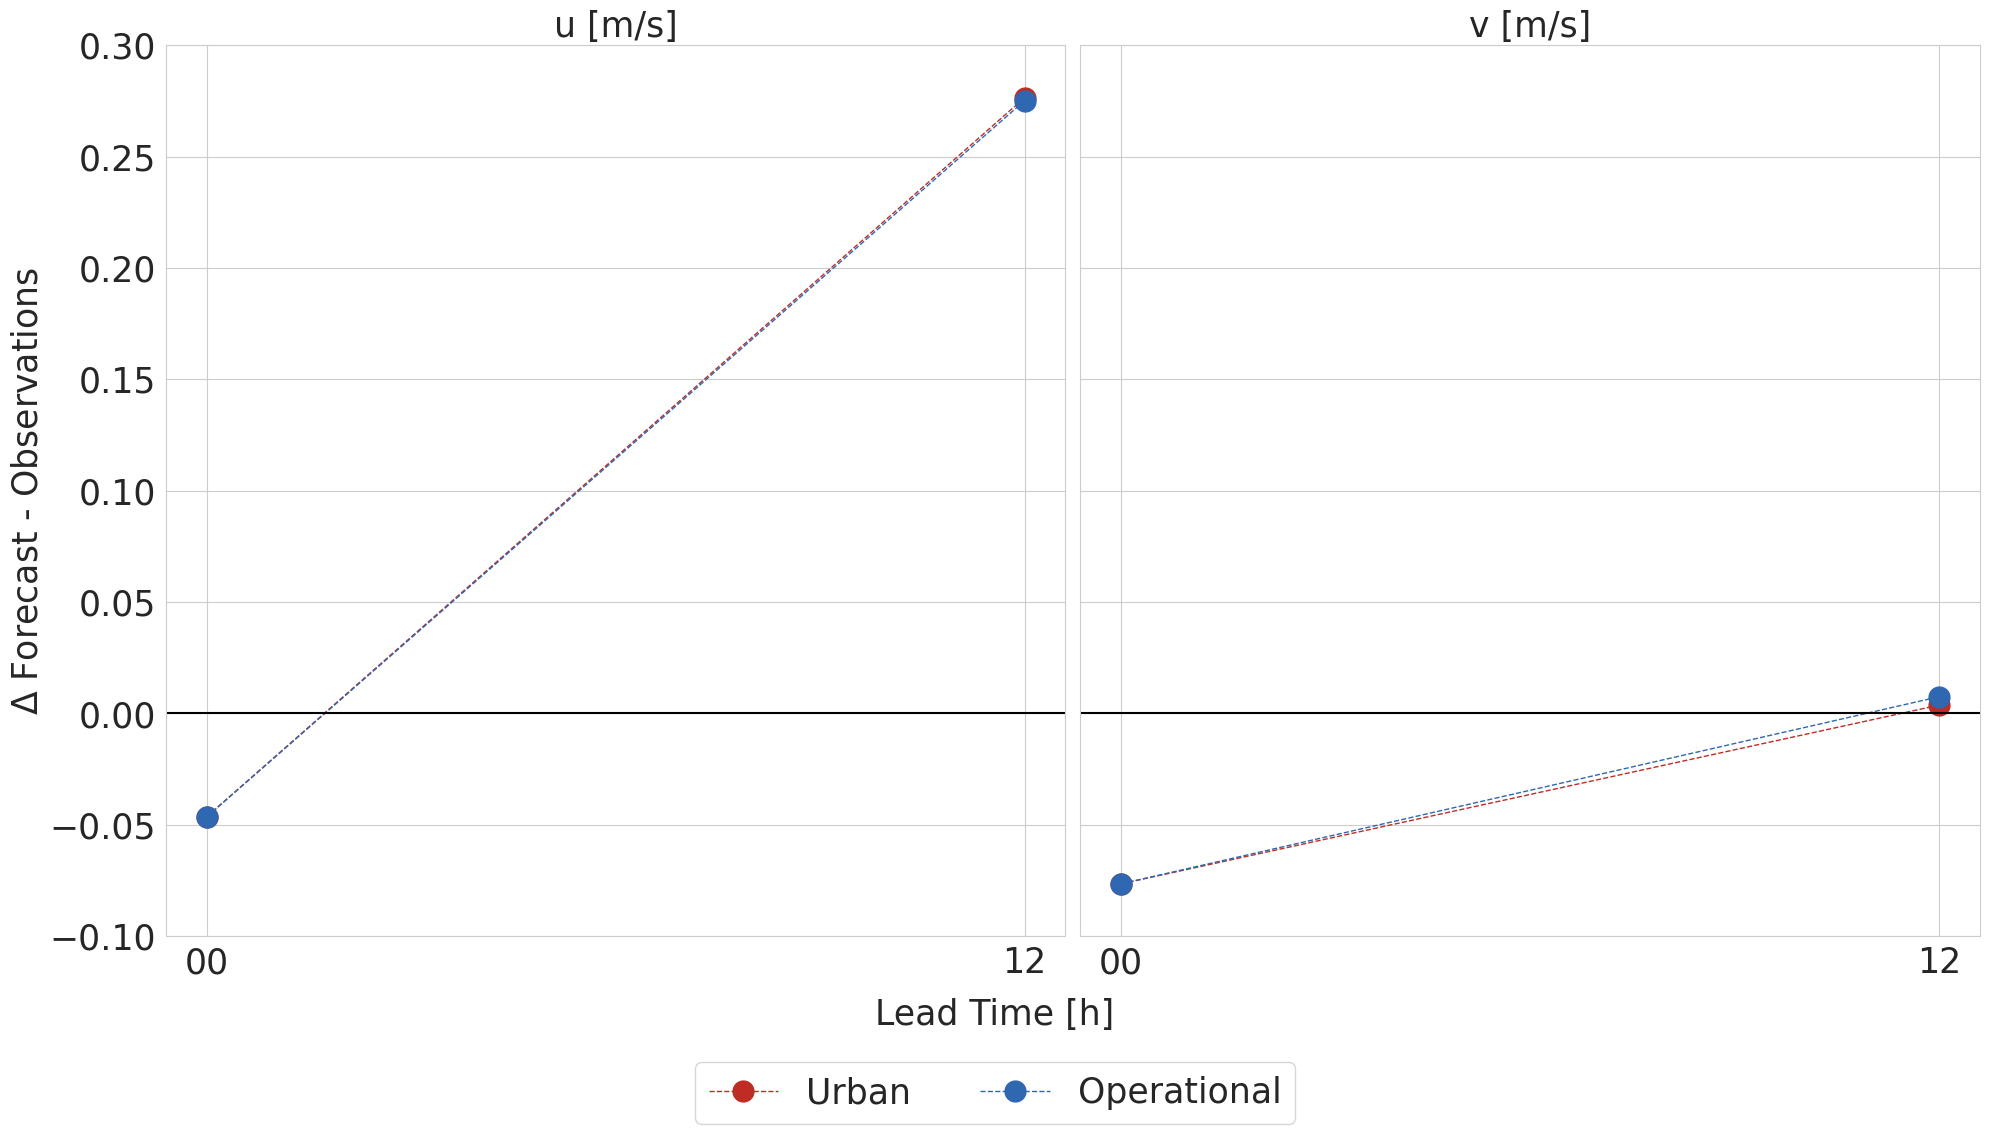

In [213]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot,
    'urban_00h': urb_00_pilot,
    'operational_12h': opr_12_pilot,
    'urban_12h': urb_12_pilot,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
 #   ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')
    ax[i].set_ylim(-0.1, 0.3)

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.text(0.5, -0.03, 'Lead Time [h]', ha='center', fontsize=25)



plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_global_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [14]:
np.unique(opr_00_airep.varno)

array([ 2.,  3.,  4., 29.], dtype=float32)

In [15]:
np.unique(opr_00_temp.varno)

array([ 1.,  2.,  3.,  4., 29.], dtype=float32)

In [87]:
p_levels = np.round(np.arange(opr_00_airep.plevel.values.min(), opr_00_airep.plevel.values.max(), 10000),2)

In [88]:
closest_values = []

for p_level in p_levels:
    closest_value = opr_00_airep.plevel.values[np.argmin(np.abs(opr_00_airep.plevel.values - p_level))]
    closest_values.append(closest_value)

print(closest_values)

[14747.682, 24764.725, 34738.01, 44836.0, 54745.71, 64696.074, 74776.414, 84763.734, 94889.875]


In [89]:
closest_values = []

for p_level in p_levels:
    closest_value = urb_00_airep.plevel.values[np.argmin(np.abs(urb_00_airep.plevel.values - p_level))]
    closest_values.append(closest_value)

print(closest_values)

[14747.682, 24764.725, 34738.01, 44836.0, 54745.71, 64696.074, 74776.414, 84763.734, 94889.875]


In [101]:
test_urb = [urb_12_airep.veri_data[5, :].where((urb_12_airep.plevel == 54745.71) & (urb_12_airep.varno == 2)).mean() - urb_12_airep.obs.where((urb_12_airep.plevel == 54745.71) & (urb_12_airep.varno == 2)).mean()]
test_opr = [opr_12_airep.veri_data[5, :].where((opr_12_airep.plevel == 54745.71) & (opr_12_airep.varno == 2)).mean() - opr_12_airep.obs.where((opr_12_airep.plevel == 54745.71) & (opr_12_airep.varno == 2)).mean()]


In [121]:
np.unique(opr_00_airep.varno)

array([ 2.,  3.,  4., 29.], dtype=float32)

The missing spots in the are missing data points or in 00 the OPR and URB run are identical

/tmp/ipykernel_3563132/2095414107.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


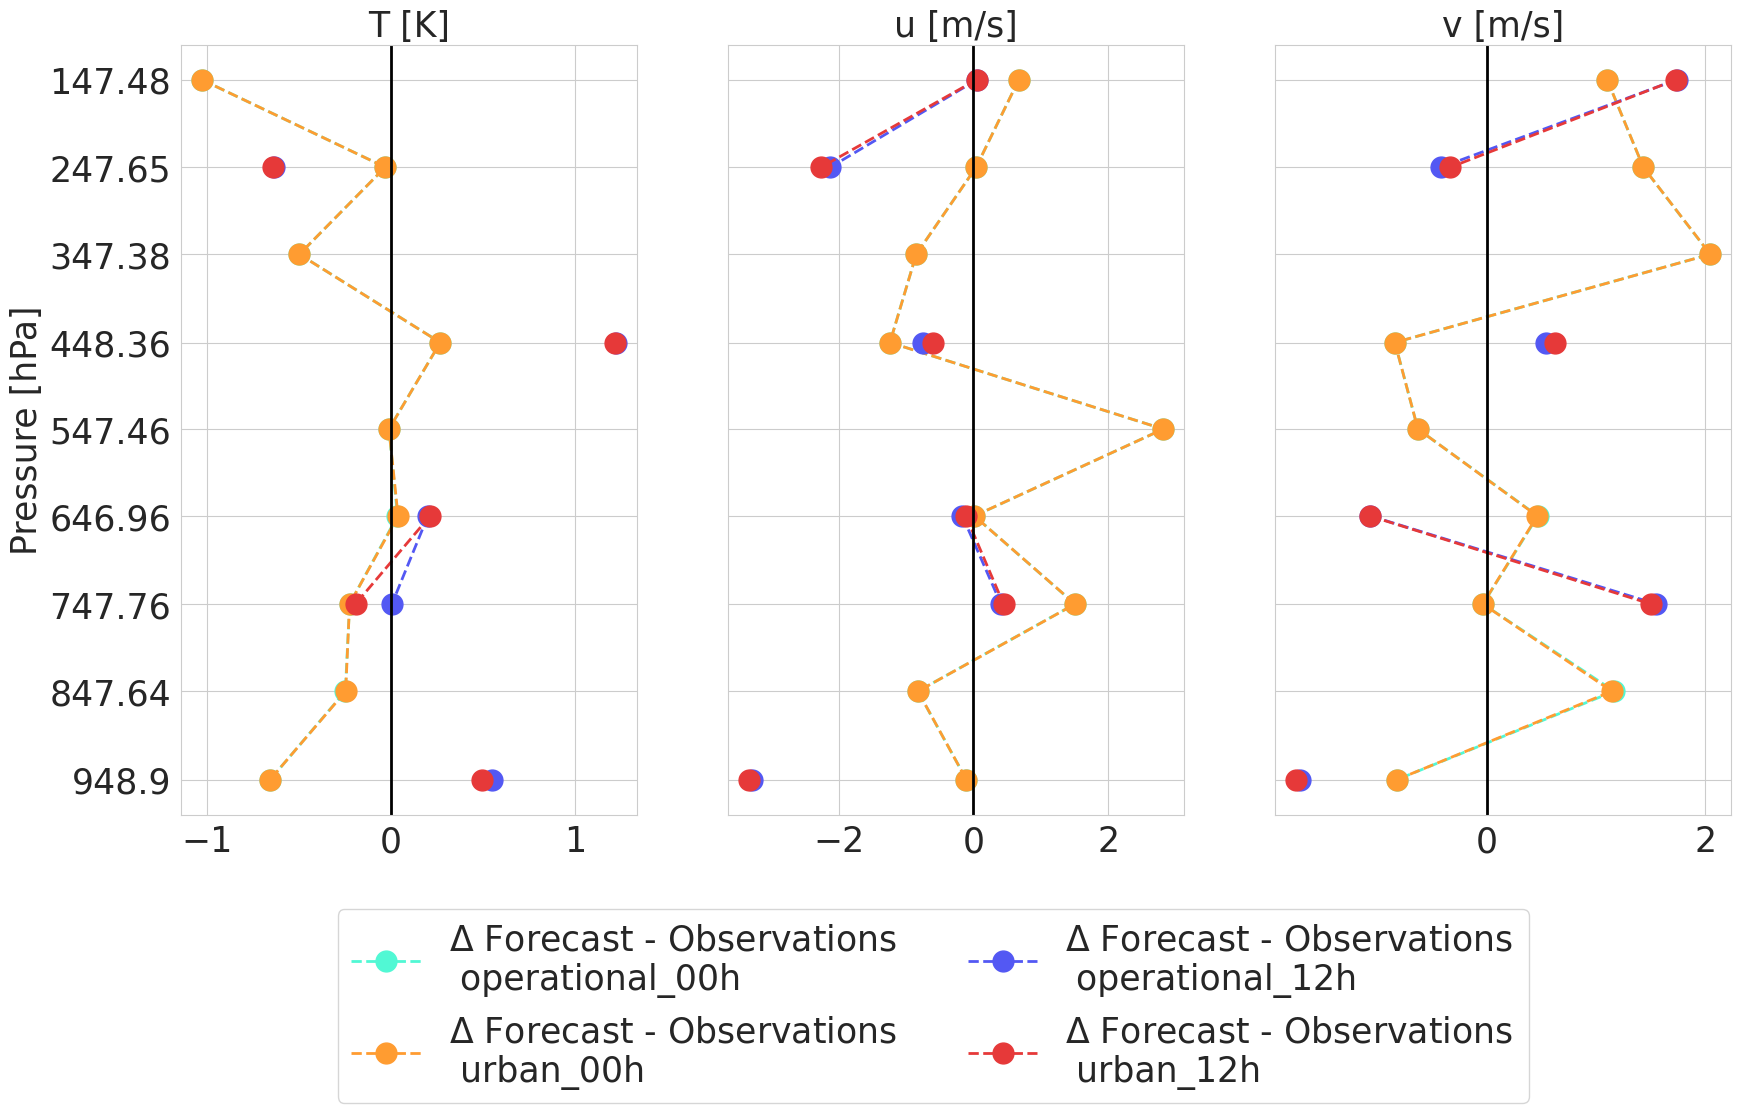

In [122]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

#p_levels = np.round(np.arange(opr_00_airep.plevel.values.min(), opr_00_airep.plevel.values.max(), 10000),2)
p_levels =closest_values
x = np.unique(opr_00_airep.varno)[:3]
varno = ['T [K]', 'u [m/s]', 'v [m/s]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

xlim_start = [-3, -1, -3.5, -3.5, -.12]
xlim_end = [2, 1, 3.5, 3.5, .12]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_airep,
    'urban_00h': urb_00_airep,
}

datasets_12 = {
    'operational_12h': opr_12_airep,
    'urban_12h': urb_12_airep,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{round(p / 100, 2)}' for p in p_levels])


    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

#for i, x_value in enumerate(x):
#    ax[i].set_xlim(xlim_start[i], xlim_end[i])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-.75, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_global_AIREP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [332]:
np.unique(opr_00_airep.varno)[:3]

array([2., 3., 4.], dtype=float32)

In [339]:
#airpep T 00

rmse_airep_00_T_opr = rmse(opr_00_airep.obs.where(opr_00_airep.varno == 2), opr_00_airep.veri_data[6,:].where(opr_00_airep.varno == 2))
rmse_airep_00_T_urb = rmse(urb_00_airep.obs.where(urb_00_airep.varno == 2), urb_00_airep.veri_data[6,:].where(urb_00_airep.varno == 2))
print(np.round(rmse_airep_00_T_opr,4))
print(np.round(rmse_airep_00_T_urb,4))
print(np.round((1 - rmse_airep_00_T_urb/rmse_airep_00_T_opr) * 100,2))

<xarray.DataArray ()>
array(0.7464, dtype=float32)
<xarray.DataArray ()>
array(0.7468, dtype=float32)
<xarray.DataArray ()>
array(-0.06)


In [340]:
#airpep T 12

rmse_airep_12_T_opr = rmse(opr_12_airep.obs.where(opr_12_airep.varno == 2), opr_12_airep.veri_data[5,:].where(opr_12_airep.varno == 2))
rmse_airep_12_T_urb = rmse(urb_12_airep.obs.where(urb_12_airep.varno == 2), urb_12_airep.veri_data[5,:].where(urb_12_airep.varno == 2))
print(np.round(rmse_airep_12_T_opr,4))
print(np.round(rmse_airep_12_T_urb,4))
print(np.round((1 - rmse_airep_12_T_urb/rmse_airep_12_T_opr) * 100,2))

<xarray.DataArray ()>
array(0.9876, dtype=float32)
<xarray.DataArray ()>
array(0.9845, dtype=float32)
<xarray.DataArray ()>
array(0.31)


In [342]:
#airpep u 00

rmse_airep_00_u_opr = rmse(opr_00_airep.obs.where(opr_00_airep.varno == 3), opr_00_airep.veri_data[6,:].where(opr_00_airep.varno == 3))
rmse_airep_00_u_urb = rmse(urb_00_airep.obs.where(urb_00_airep.varno == 3), urb_00_airep.veri_data[6,:].where(urb_00_airep.varno == 3))
print(np.round(rmse_airep_00_u_opr,4))
print(np.round(rmse_airep_00_u_urb,4))
print(np.round((1 - rmse_airep_00_u_urb/rmse_airep_00_u_opr) * 100,2))

<xarray.DataArray ()>
array(2.2234, dtype=float32)
<xarray.DataArray ()>
array(2.224, dtype=float32)
<xarray.DataArray ()>
array(-0.03)


In [345]:
#airpep u 12

rmse_airep_12_u_opr = rmse(opr_12_airep.obs.where(opr_12_airep.varno == 3), opr_12_airep.veri_data[5,:].where(opr_12_airep.varno == 3))
rmse_airep_12_u_urb = rmse(urb_12_airep.obs.where(urb_12_airep.varno == 3), urb_12_airep.veri_data[5,:].where(urb_12_airep.varno == 3))
print(np.round(rmse_airep_12_u_opr,4))
print(np.round(rmse_airep_12_u_urb,4))
print(np.round((1 - rmse_airep_12_u_urb/rmse_airep_12_u_opr) * 100,2))

<xarray.DataArray ()>
array(3.3179, dtype=float32)
<xarray.DataArray ()>
array(3.3271, dtype=float32)
<xarray.DataArray ()>
array(-0.28)


In [347]:
#airpep v 00

rmse_airep_00_v_opr = rmse(opr_00_airep.obs.where(opr_00_airep.varno == 4), opr_00_airep.veri_data[6,:].where(opr_00_airep.varno == 4))
rmse_airep_00_v_urb = rmse(urb_00_airep.obs.where(urb_00_airep.varno == 4), urb_00_airep.veri_data[6,:].where(urb_00_airep.varno == 4))
print(np.round(rmse_airep_00_v_opr,4))
print(np.round(rmse_airep_00_v_urb,4))
print(np.round((1 - rmse_airep_00_v_urb/rmse_airep_00_v_opr) * 100,2))

<xarray.DataArray ()>
array(2.2544, dtype=float32)
<xarray.DataArray ()>
array(2.2544, dtype=float32)
<xarray.DataArray ()>
array(0.)


In [348]:
#airpep u 12

rmse_airep_12_v_opr = rmse(opr_12_airep.obs.where(opr_12_airep.varno == 4), opr_12_airep.veri_data[5,:].where(opr_12_airep.varno == 4))
rmse_airep_12_v_urb = rmse(urb_12_airep.obs.where(urb_12_airep.varno == 4), urb_12_airep.veri_data[5,:].where(urb_12_airep.varno == 4))
print(np.round(rmse_airep_12_v_opr,4))
print(np.round(rmse_airep_12_v_urb,4))
print(np.round((1 - rmse_airep_12_v_urb/rmse_airep_12_v_opr) * 100,2))

<xarray.DataArray ()>
array(3.0718, dtype=float32)
<xarray.DataArray ()>
array(3.0782, dtype=float32)
<xarray.DataArray ()>
array(-0.21)


/tmp/ipykernel_3563132/2126581074.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


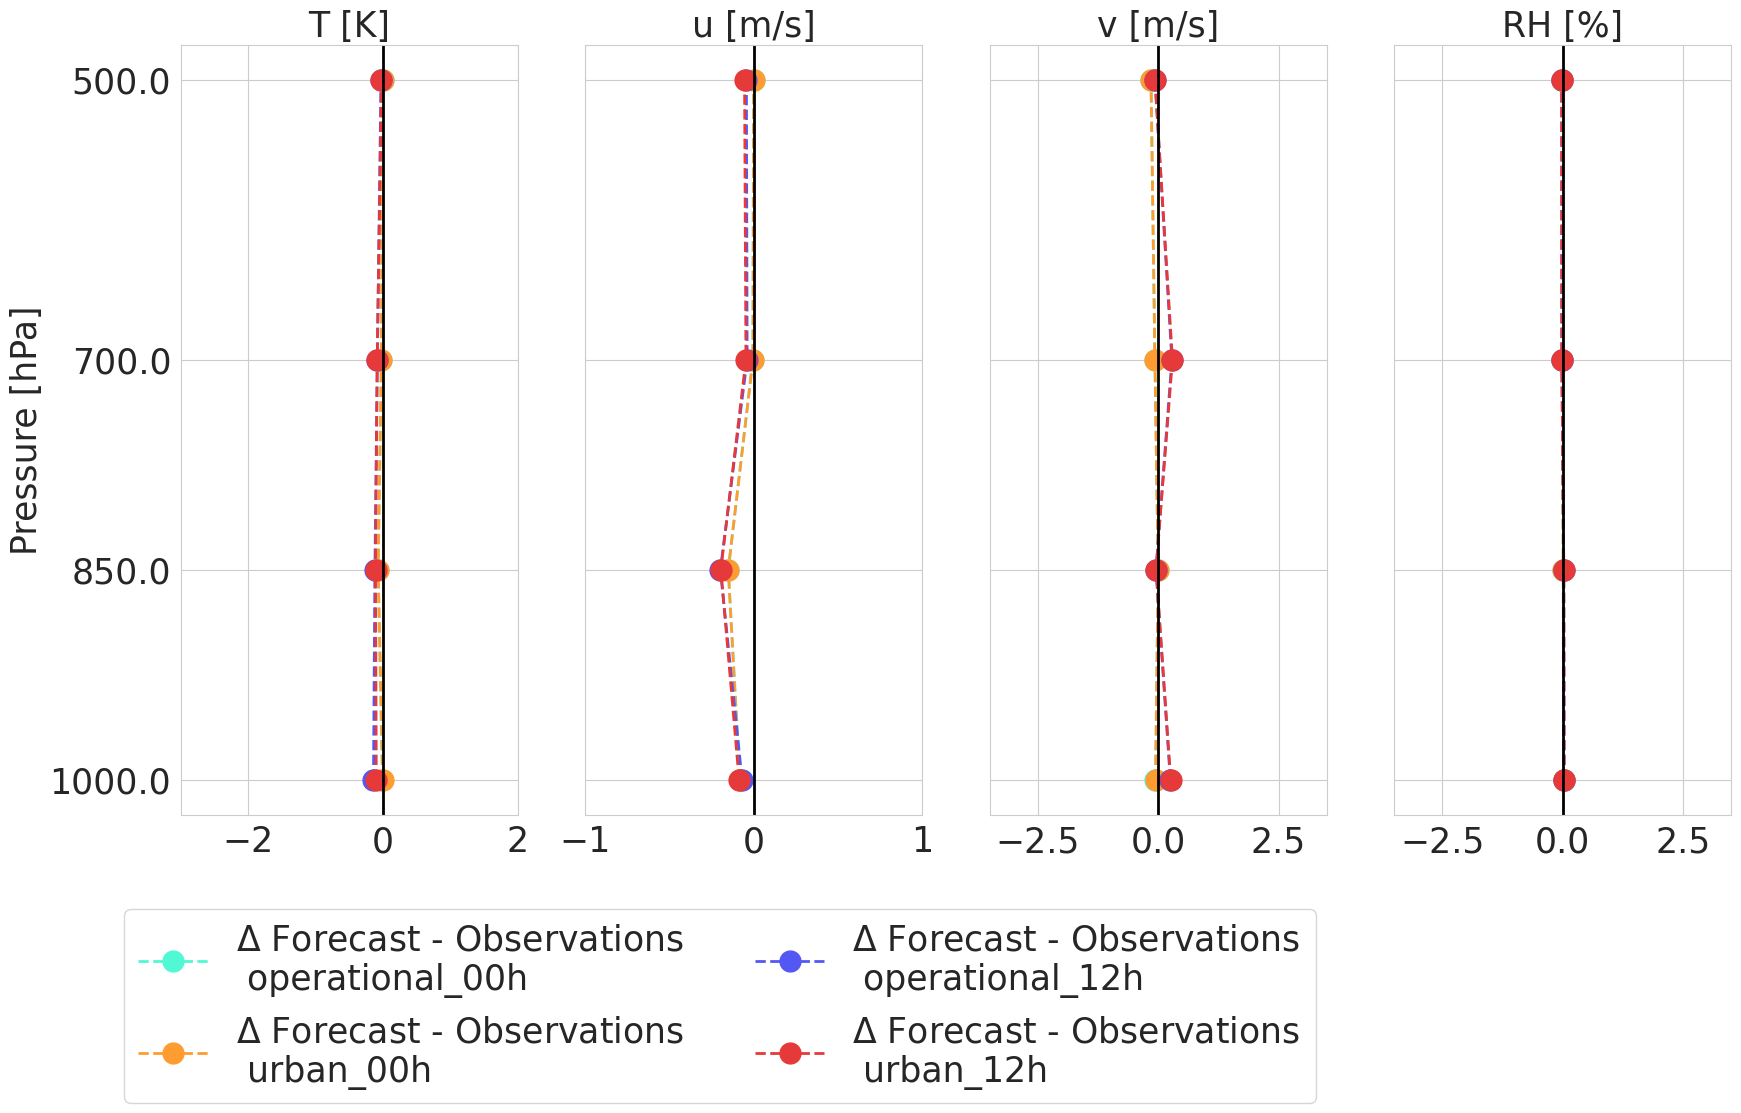

In [130]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)[-4:]
varno = ['T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

#'Geopotential [$(m/s)^2$]'
# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

xlim_start = [-3, -1, -3.5, -3.5, -.12]
xlim_end = [2, 1, 3.5, 3.5, .12]


fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp,
    'urban_00h': urb_00_temp,
}

datasets_12 = {
    'operational_12h': opr_12_temp,
    'urban_12h': urb_12_temp,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

for i, x_value in enumerate(x):
    ax[i].set_xlim(xlim_start[i], xlim_end[i])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_global_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


### RMSE calculations

In [129]:
np.unique(opr_00_temp.varno)[-4:]

array([ 2.,  3.,  4., 29.], dtype=float32)

In [222]:
#Temperature 00

rmse_temp_00_T_opr = [rmse(opr_00_temp.veri_data[6,:].where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 2)), opr_00_temp.obs.where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 2))) for p in p_levels]
rmse_temp_00_T_urb = [rmse(urb_00_temp.veri_data[6,:].where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 2)), urb_00_temp.obs.where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 2))) for p in p_levels]
print(np.round(rmse_temp_00_T_opr,4))
print(np.round(rmse_temp_00_T_urb,4))
np.round([(1 - rmse_temp_00_T_urb[i]/rmse_temp_00_T_opr[i]) * 100 for i in range(4)],2)

[1.0317 0.8164 0.5971 0.6351]
[1.0348 0.8113 0.595  0.6357]


array([-0.3 ,  0.62,  0.35, -0.1 ])

In [225]:
#Temperature 12

rmse_temp_12_T_opr = [rmse(opr_12_temp.veri_data[5,:].where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 2)), opr_12_temp.obs.where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 2))) for p in p_levels]
rmse_temp_12_T_urb = [rmse(urb_12_temp.veri_data[5,:].where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 2)), urb_12_temp.obs.where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 2))) for p in p_levels]
print(np.round(rmse_temp_12_T_opr,4))
print(np.round(rmse_temp_12_T_urb,4))
np.round([(1 - rmse_temp_12_T_urb[i]/rmse_temp_12_T_opr[i]) * 100 for i in range(4)],2)

[1.2806 1.0697 0.8927 0.8473]
[1.2488 1.0687 0.8843 0.834 ]


array([2.48, 0.09, 0.94, 1.57])

In [227]:
#u 00

rmse_temp_00_u_opr = [rmse(opr_00_temp.veri_data[6,:].where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 3)), opr_00_temp.obs.where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 3))) for p in p_levels]
rmse_temp_00_u_urb = [rmse(urb_00_temp.veri_data[6,:].where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 3)), urb_00_temp.obs.where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 3))) for p in p_levels]
print(np.round(rmse_temp_00_u_opr,4))
print(np.round(rmse_temp_00_u_urb,4))
np.round([(1 - rmse_temp_00_u_urb[i]/rmse_temp_00_u_opr[i]) * 100 for i in range(4)],2)

[1.7252 1.9453 1.8454 2.1808]
[1.7289 1.9454 1.8456 2.1798]


array([-0.22, -0.01, -0.01,  0.05])

In [230]:
#u 12

rmse_temp_12_u_opr = [rmse(opr_12_temp.veri_data[5,:].where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 3)), opr_12_temp.obs.where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 3))) for p in p_levels]
rmse_temp_12_u_urb = [rmse(urb_12_temp.veri_data[5,:].where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 3)), urb_12_temp.obs.where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 3))) for p in p_levels]
print(np.round(rmse_temp_12_u_opr,4))
print(np.round(rmse_temp_12_u_urb,4))
np.round([(1 - rmse_temp_12_u_urb[i]/rmse_temp_12_u_opr[i]) * 100 for i in range(4)],2)

[1.982  2.4257 2.5013 2.9637]
[1.9906 2.418  2.5085 2.9811]


array([-0.44,  0.32, -0.29, -0.59])

In [232]:
#v 00

rmse_temp_00_v_opr = [rmse(opr_00_temp.veri_data[6,:].where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 4)), opr_00_temp.obs.where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 4))) for p in p_levels]
rmse_temp_00_v_urb = [rmse(urb_00_temp.veri_data[6,:].where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 4)), urb_00_temp.obs.where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 4))) for p in p_levels]
print(np.round(rmse_temp_00_v_opr,4))
print(np.round(rmse_temp_00_v_urb,4))
np.round([(1 - rmse_temp_00_v_urb[i]/rmse_temp_00_v_opr[i]) * 100 for i in range(4)],2)

[1.8386 1.8416 1.9788 2.0547]
[1.8392 1.8433 1.9789 2.054 ]


array([-0.04, -0.09, -0.01,  0.03])

In [236]:
#v 12

rmse_temp_12_v_opr = [rmse(opr_12_temp.veri_data[5,:].where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 4)), opr_12_temp.obs.where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 4))) for p in p_levels]
rmse_temp_12_v_urb = [rmse(urb_12_temp.veri_data[5,:].where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 4)), urb_12_temp.obs.where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 4))) for p in p_levels]
print(np.round(rmse_temp_12_v_opr,4))
print(np.round(rmse_temp_12_v_urb,4))
np.round([(1 - rmse_temp_12_v_urb[i]/rmse_temp_12_v_opr[i]) * 100 for i in range(4)],2)

[2.0235 2.4969 2.1639 2.7697]
[2.0253 2.4776 2.1613 2.7666]


array([-0.09,  0.77,  0.12,  0.11])

In [237]:
#RH 00

rmse_temp_00_RH_opr = [rmse(opr_00_temp.veri_data[6,:].where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 29)), opr_00_temp.obs.where((opr_00_temp.plevel == p) & (opr_00_temp.varno == 29))) for p in p_levels]
rmse_temp_00_RH_urb = [rmse(urb_00_temp.veri_data[6,:].where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 29)), urb_00_temp.obs.where((urb_00_temp.plevel == p) & (urb_00_temp.varno == 29))) for p in p_levels]
print(np.round(rmse_temp_00_RH_opr,4))
print(np.round(rmse_temp_00_RH_urb,4))
np.round([(1 - rmse_temp_00_RH_urb[i]/rmse_temp_00_RH_opr[i]) * 100 for i in range(4)],2)

[0.0747 0.0911 0.0967 0.1047]
[0.0751 0.0911 0.0965 0.1045]


array([-0.53,  0.05,  0.22,  0.12])

In [238]:
#RH 12

rmse_temp_12_RH_opr = [rmse(opr_12_temp.veri_data[5,:].where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 29)), opr_12_temp.obs.where((opr_12_temp.plevel == p) & (opr_12_temp.varno == 29))) for p in p_levels]
rmse_temp_12_RH_urb = [rmse(urb_12_temp.veri_data[5,:].where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 29)), urb_12_temp.obs.where((urb_12_temp.plevel == p) & (urb_12_temp.varno == 29))) for p in p_levels]
print(np.round(rmse_temp_12_RH_opr,4))
print(np.round(rmse_temp_12_RH_urb,4))
np.round([(1 - rmse_temp_12_RH_urb[i]/rmse_temp_12_RH_opr[i]) * 100 for i in range(4)],2)

[0.0909 0.1226 0.1392 0.1702]
[0.0879 0.1231 0.1393 0.1693]


array([ 3.22, -0.42, -0.06,  0.55])

## European Verification

xr.sel would be a more elegant way to slice the data, but it doesn't work, since lat lon are non-indexed multidimensional coordinates. It is discussed here
https://github.com/pydata/xarray/issues/2028

In [109]:
#filter european domain by where command with lon lat valules

urb_00_pilot_europe = urb_00_pilot.where((urb_00_pilot.lat >= 20) & (urb_00_pilot.lat <= 80) & (urb_00_pilot.lon >= -10) & (urb_00_pilot.lon <= 30), drop=True)
urb_12_pilot_europe = urb_12_pilot.where((urb_12_pilot.lat >= 20) & (urb_12_pilot.lat <= 80) & (urb_12_pilot.lon >= -10) & (urb_12_pilot.lon <= 30), drop=True)

opr_00_pilot_europe = opr_00_pilot.where((opr_00_pilot.lat >= 20) & (opr_00_pilot.lat <= 80) & (opr_00_pilot.lon >= -10) & (opr_00_pilot.lon <= 30), drop=True)
opr_12_pilot_europe = opr_12_pilot.where((opr_12_pilot.lat >= 20) & (opr_12_pilot.lat <= 80) & (opr_12_pilot.lon >= -10) & (opr_12_pilot.lon <= 30), drop=True)

urb_00_synop_europe = urb_00_synop.where((urb_00_synop.lat >= 20) & (urb_00_synop.lat <= 80) & (urb_00_synop.lon >= -10) & (urb_00_synop.lon <= 30), drop=True)
urb_12_synop_europe = urb_12_synop.where((urb_12_synop.lat >= 20) & (urb_12_synop.lat <= 80) & (urb_12_synop.lon >= -10) & (urb_12_synop.lon <= 30), drop=True)

opr_00_synop_europe = opr_00_synop.where((opr_00_synop.lat >= 20) & (opr_00_synop.lat <= 80) & (opr_00_synop.lon >= -10) & (opr_00_synop.lon <= 30), drop=True)
opr_12_synop_europe = opr_12_synop.where((opr_12_synop.lat >= 20) & (opr_12_synop.lat <= 80) & (opr_12_synop.lon >= -10) & (opr_12_synop.lon <= 30), drop=True)

urb_00_temp_europe = urb_00_temp.where((urb_00_temp.lat >= 20) & (urb_00_temp.lat <= 80) & (urb_00_temp.lon >= -10) & (urb_00_temp.lon <= 30), drop=True)
urb_12_temp_europe = urb_12_temp.where((urb_12_temp.lat >= 20) & (urb_12_temp.lat <= 80) & (urb_12_temp.lon >= -10) & (urb_12_temp.lon <= 30), drop=True)

opr_00_temp_europe = opr_00_temp.where((opr_00_temp.lat >= 20) & (opr_00_temp.lat <= 80) & (opr_00_temp.lon >= -10) & (opr_00_temp.lon <= 30), drop=True)
opr_12_temp_europe = opr_12_temp.where((opr_12_temp.lat >= 20) & (opr_12_temp.lat <= 80) & (opr_12_temp.lon >= -10) & (opr_12_temp.lon <= 30), drop=True)


ValueError: cannot reindex or align along dimension 'd_body' because of conflicting dimension sizes: {61056, 10269}

In [110]:
urb_00_airep_europe = urb_00_airep.where((urb_00_airep.lat >= 20) & (urb_00_airep.lat <= 80) & (urb_00_airep.lon >= -10) & (urb_00_airep.lon <= 30), drop=True)
urb_12_airep_europe = urb_12_airep.where((urb_12_airep.lat >= 20) & (urb_12_airep.lat <= 80) & (urb_12_airep.lon >= -10) & (urb_12_airep.lon <= 30), drop=True)

opr_00_airep_europe = opr_00_airep.where((opr_00_airep.lat >= 20) & (opr_00_airep.lat <= 80) & (opr_00_airep.lon >= -10) & (opr_00_airep.lon <= 30), drop=True)
opr_12_airep_europe = opr_12_airep.where((opr_12_airep.lat >= 20) & (opr_12_airep.lat <= 80) & (opr_12_airep.lon >= -10) & (opr_12_airep.lon <= 30), drop=True)

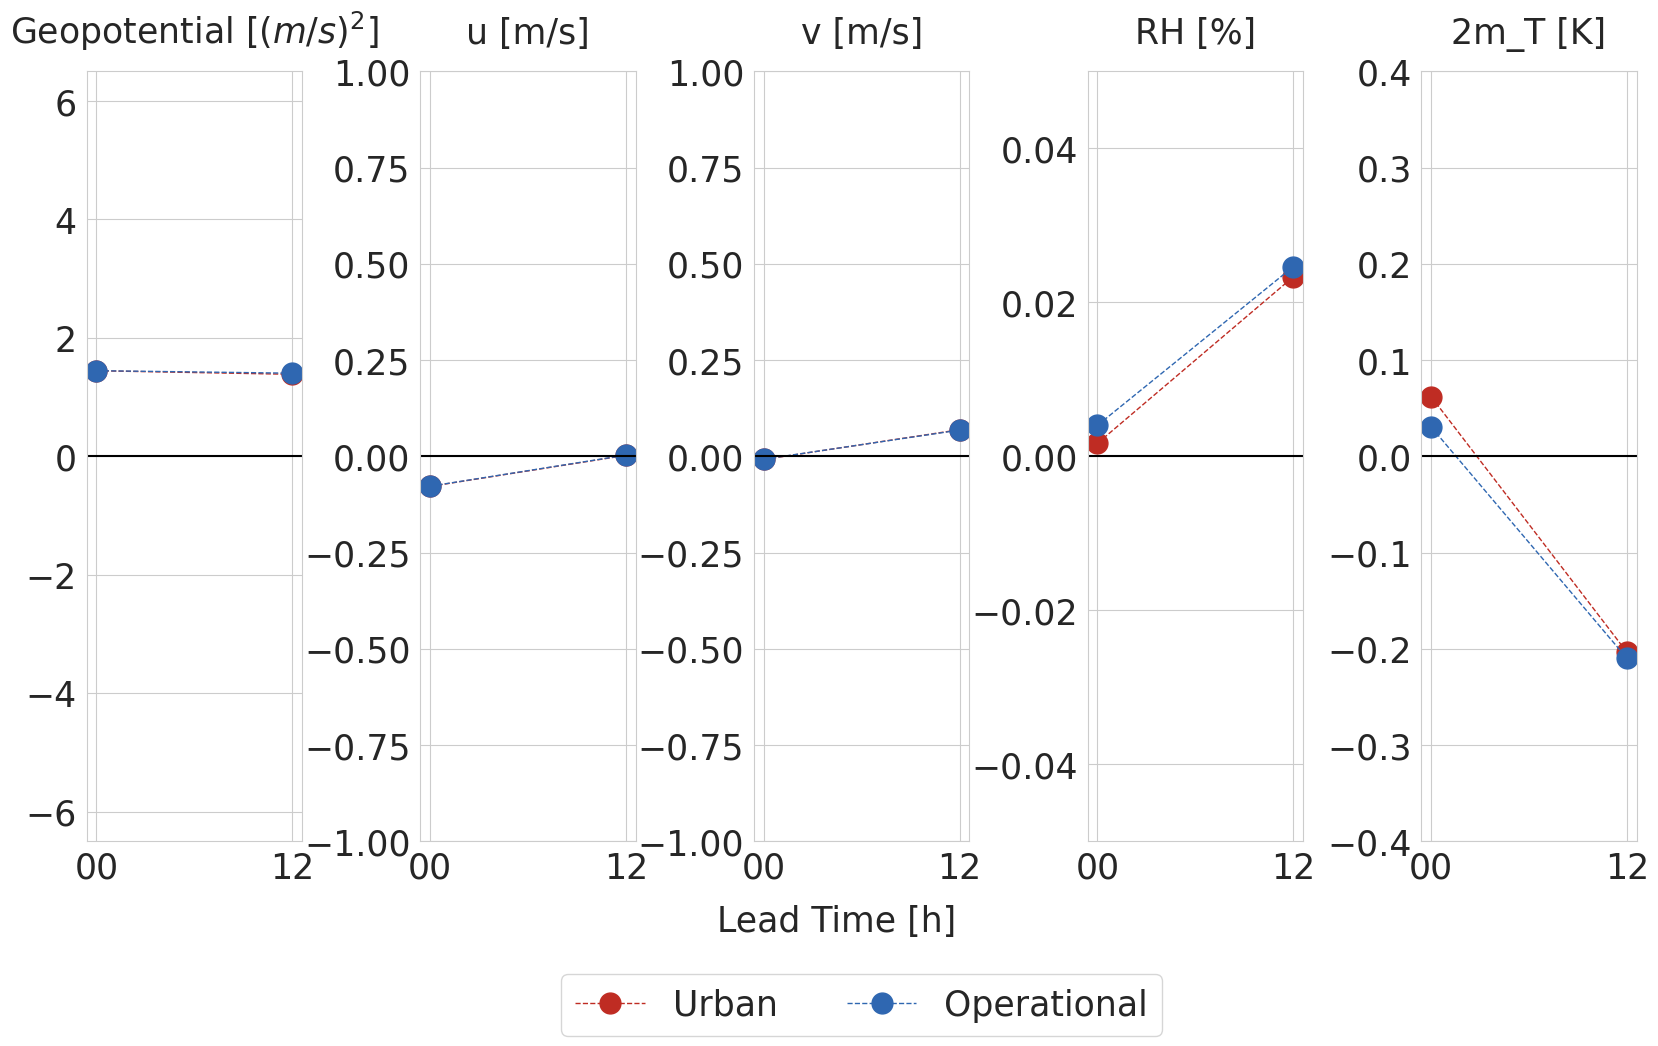

In [133]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']

xlim_start = [-6.5, -1, -1, -.05, -.4]
xlim_end = [6.5, 1, 1, .05, .4]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10))

dataset = {
    'operational_00h': opr_00_synop_europe,
    'urban_00h': urb_00_synop_europe,
    'operational_12h': opr_12_synop_europe,
    'urban_12h': urb_12_synop_europe,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')

    ax[i].set_title(varno[i], pad = 20)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2.6, -0.15), ncol=2)

for i, x_value in enumerate(x):
    ax[i].set_ylim(xlim_start[i], xlim_end[i])

fig.text(0.5, 0.02, 'Lead Time [h]', ha='center', fontsize=25)
fig.subplots_adjust(wspace=0.55) 

plt.savefig('../plots_2024/verification/verification_europe_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')
plt.show()


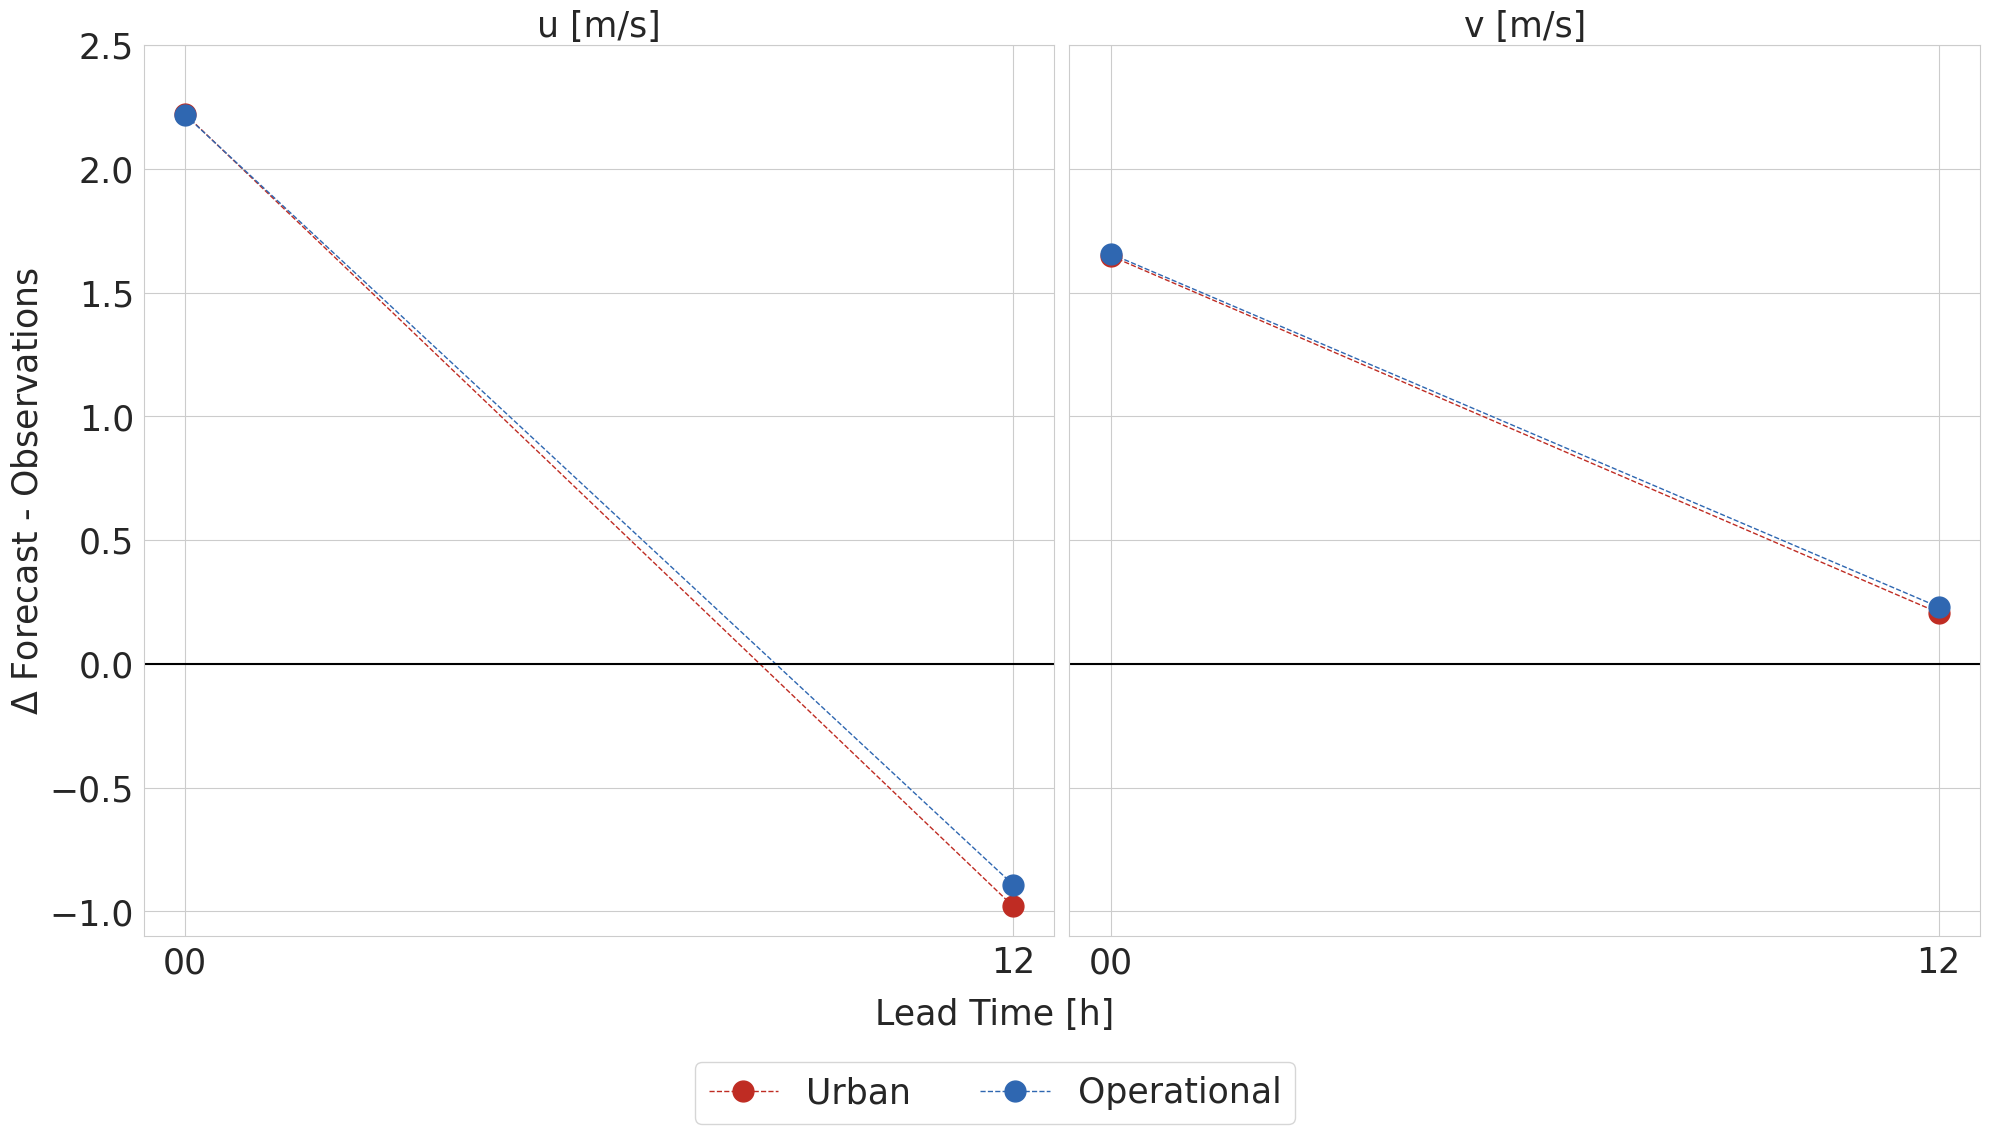

In [181]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_europe,
    'urban_00h': urb_00_pilot_europe,
    'operational_12h': opr_12_pilot_europe,
    'urban_12h': urb_12_pilot_europe,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')
#    ax[i].plot([1, 2], [opr_12_3hlt, opr_24_3hlt], marker='o', color='r', linestyle='--', linewidth=3, label='Operational 3h leadtime')
#    ax[i].set_ylabel(f'$\Delta$ Forecast - Observations [{y_label[i]}]')

    ax[i].set_title(varno[i])
 #   ax[-1].legend()
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')
    ax[i].set_ylim(-1.1, 2.5)
    
ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.text(0.5, -0.03, 'Lead Time [h]', ha='center', fontsize=25)


plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_europe_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
test_urb = [urb_12_airep_europe.veri_data[5, :].where((urb_12_airep.plevel == 54745.71) & (urb_12_airep.varno == 2)).mean() - urb_12_airep.obs.where((urb_12_airep.plevel == 54745.71) & (urb_12_airep.varno == 2)).mean()]
test_opr = [opr_12_airep_europe.veri_data[5, :].where((opr_12_airep.plevel == 54745.71) & (opr_12_airep.varno == 2)).mean() - opr_12_airep.obs.where((opr_12_airep.plevel == 54745.71) & (opr_12_airep.varno == 2)).mean()]


In [ ]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

#p_levels = np.round(np.arange(opr_00_airep.plevel.values.min(), opr_00_airep.plevel.values.max(), 10000),2)
p_levels =closest_values
x = np.unique(opr_00_airep.varno)[:3]
varno = ['T [K]', 'u [m/s]', 'v [m/s]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

xlim_start = [-3, -1, -3.5, -3.5, -.12]
xlim_end = [2, 1, 3.5, 3.5, .12]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_airep_europe,
    'urban_00h': urb_00_airep_europe,
}

datasets_12 = {
    'operational_12h': opr_12_airep_europe,
    'urban_12h': urb_12_airep_europe,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{round(p / 100, 2)}' for p in p_levels])


    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

#for i, x_value in enumerate(x):
#    ax[i].set_xlim(xlim_start[i], xlim_end[i])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-.75, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

#plt.savefig('../plots_2024/verification/verification_global_AIREP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


/tmp/ipykernel_2347203/3143538228.py:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


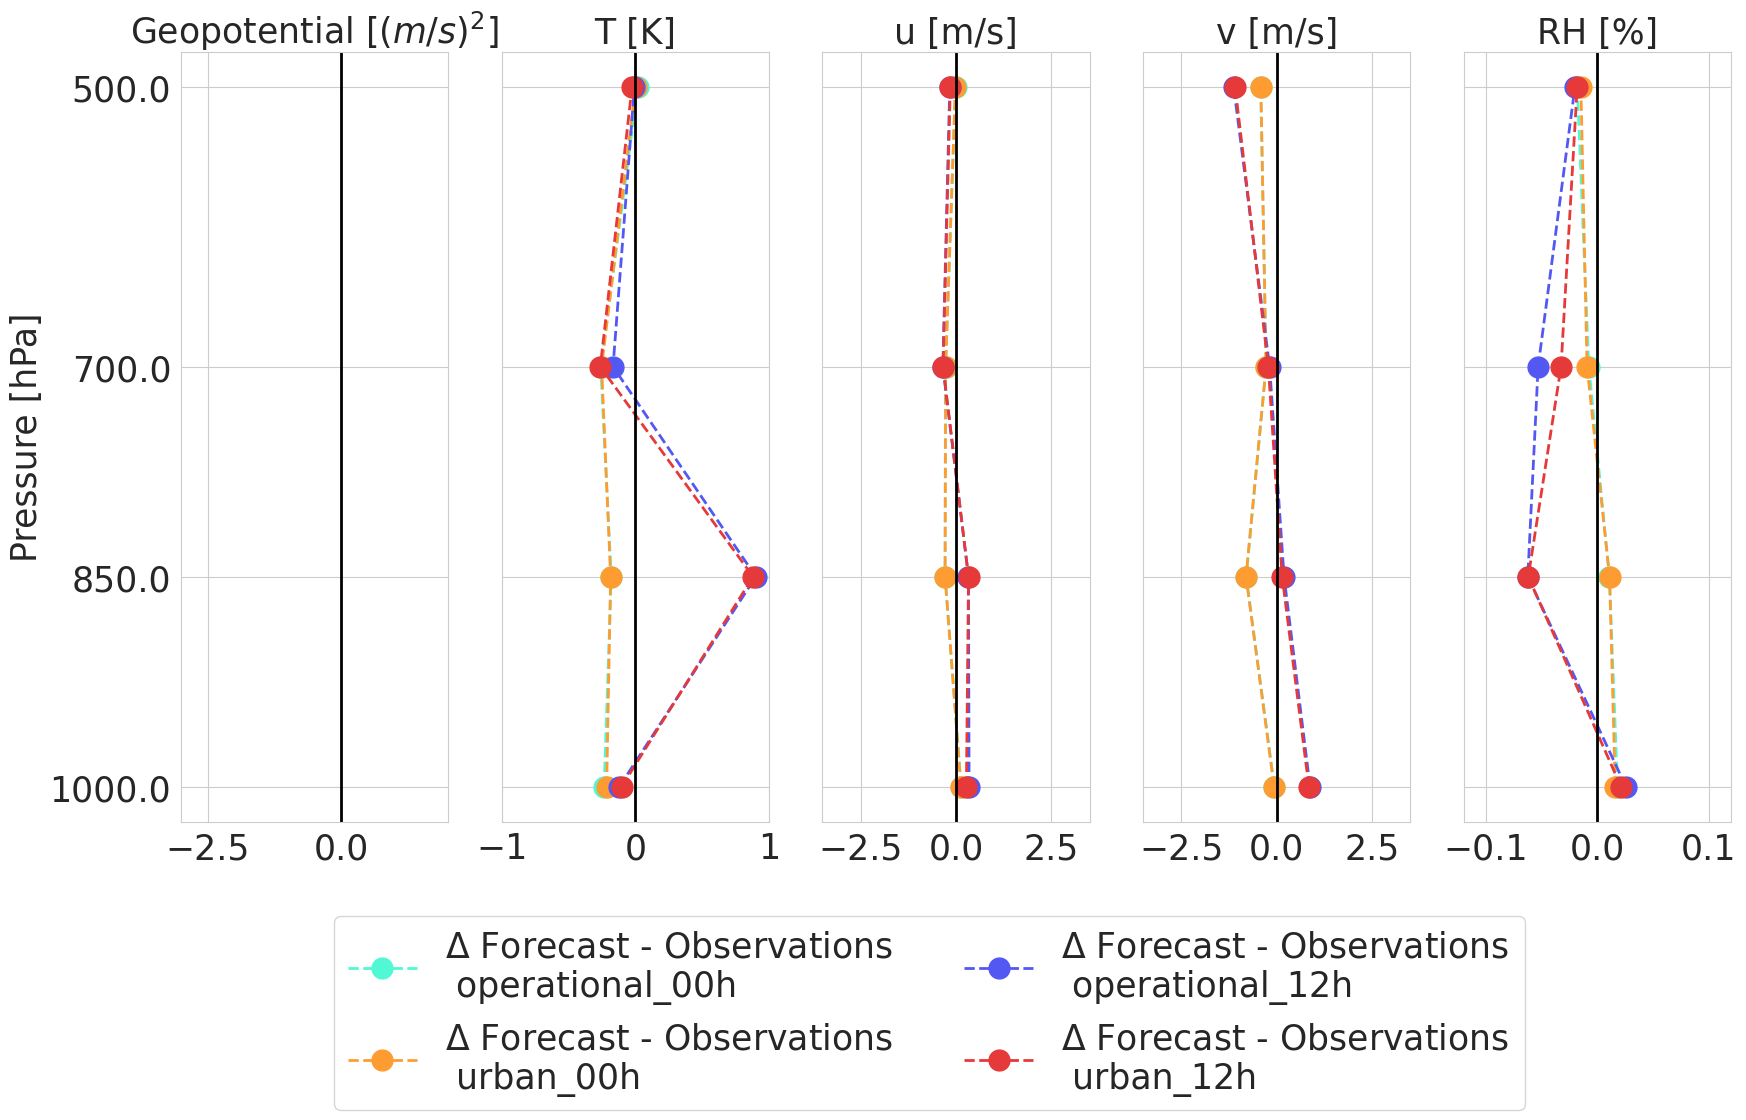

In [169]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential [$(m/s)^2$]', 'T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

xlim_start = [-3, -1, -3.5, -3.5, -.12]
xlim_end = [2, 1, 3.5, 3.5, .12]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_europe,
    'urban_00h': urb_00_temp_europe,
}

datasets_12 = {
    'operational_12h': opr_12_temp_europe,
    'urban_12h': urb_12_temp_europe,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

for i, x_value in enumerate(x):
    ax[i].set_xlim(xlim_start[i], xlim_end[i])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_europe_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


## Urban Grids Verification

In [140]:
#load dataset with lon lat values of cities, defined before

ds_det = xr.open_dataset('../det_data_all_2022/fc_DOM01_0001_NU_urban_grid.nc')

In [171]:
#select lon and lat values

ds_det["clat"] = np.degrees(ds_det["clat"])
ds_det["clon"] = np.degrees(ds_det["clon"])

In [41]:
#define K-D tree for the PILOT 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [42]:
#initialize K-D tree
tree_icon = model_kdtree()
tree_icon.kdtree

In [43]:
# apply tree to lat lon values from cities given abvoe

indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [44]:
# select accordingly in verification files

urb_00_pilot_cities = urb_00_pilot.isel(d_body=indices_cities_ens)
opr_00_pilot_cities = opr_00_pilot.isel(d_body=indices_cities_ens)

In [45]:
#define K-D tree for the PYLOT 12 data 

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512PILOT.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [46]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [47]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [48]:
urb_12_pilot_cities = urb_12_pilot.isel(d_body=indices_cities_ens)
opr_12_pilot_cities = opr_12_pilot.isel(d_body=indices_cities_ens)

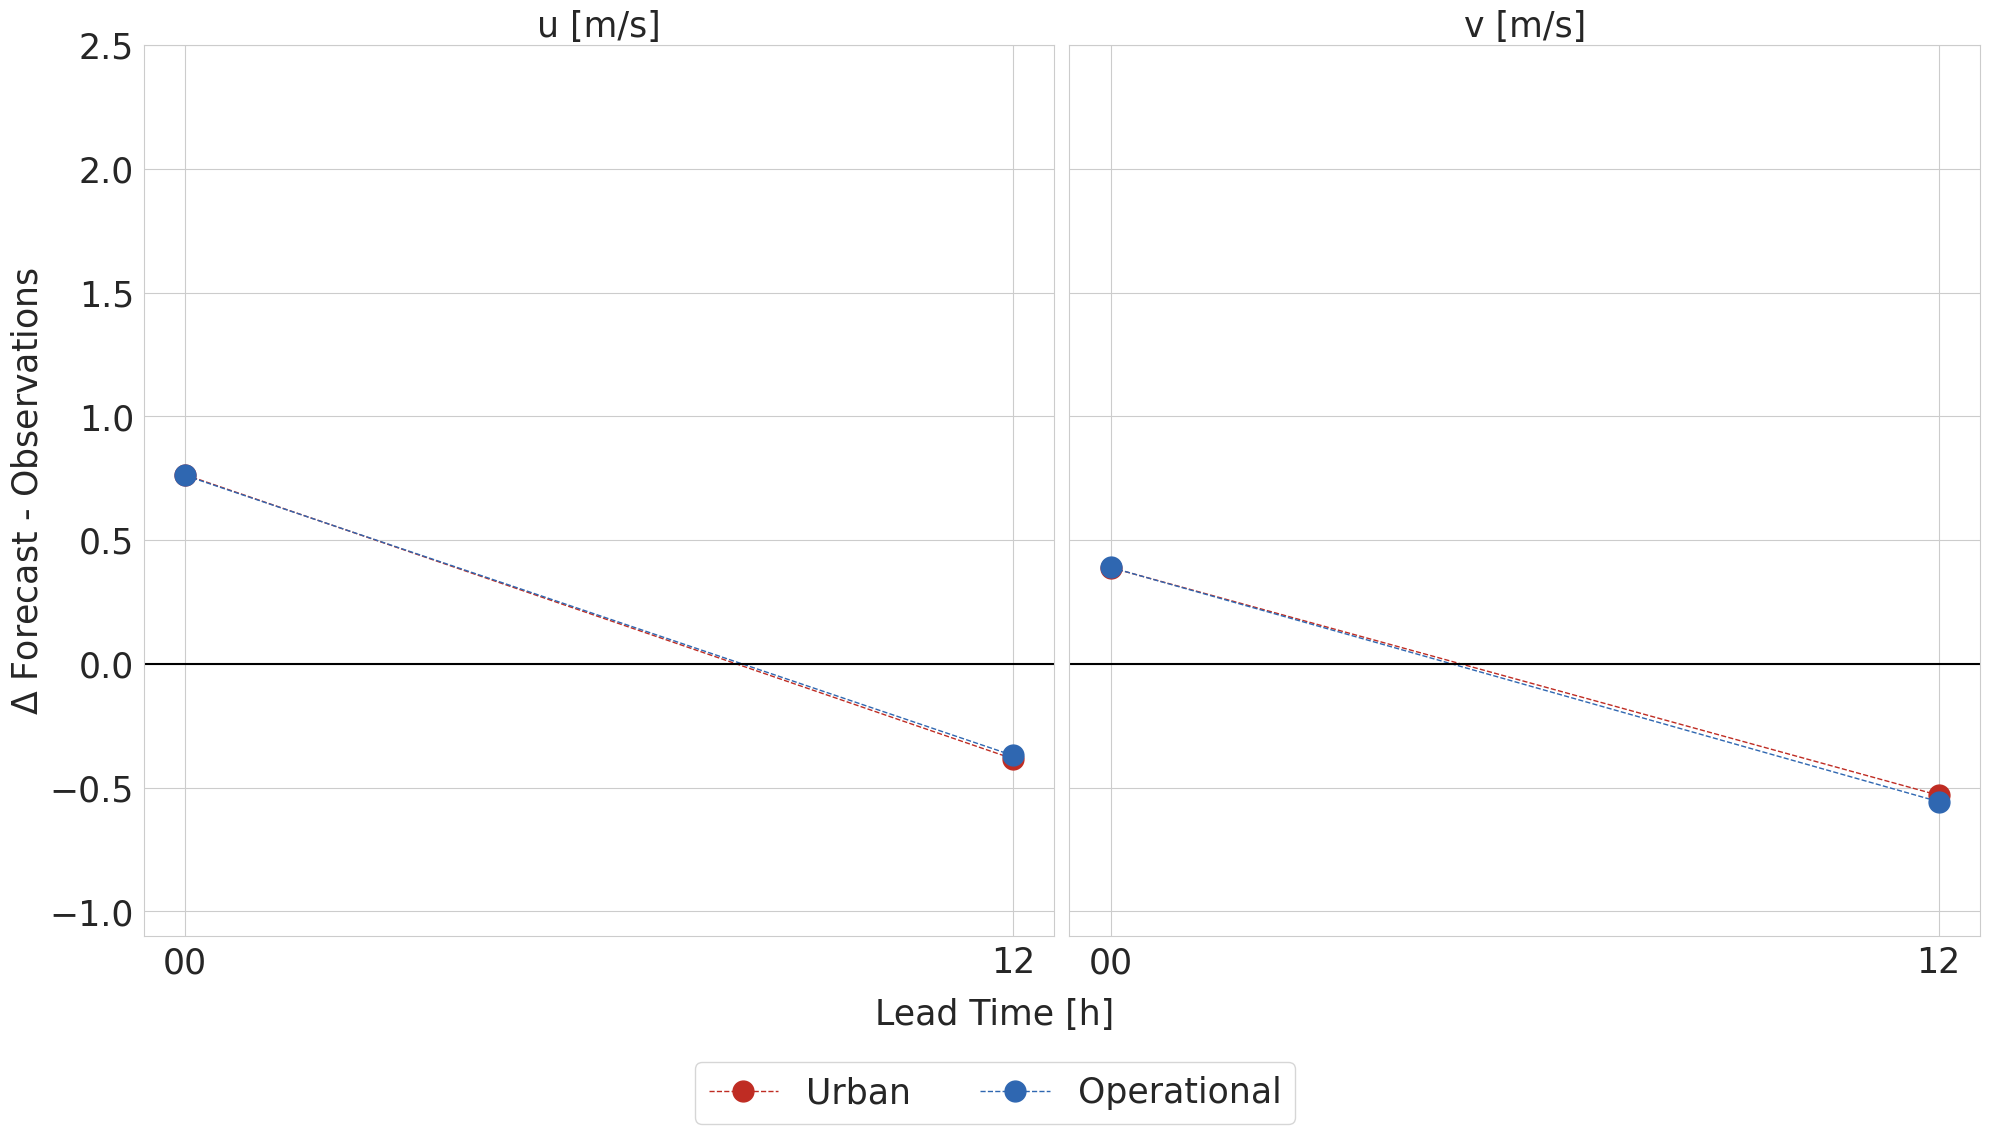

In [183]:
#plot PILOT - ballon observations globally

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_pilot.varno)
varno = ['u [m/s]', 'v [m/s]']
#y_label = ['m/s', 'm/s']

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

dataset = {
    'operational_00h': opr_00_pilot_cities,
    'urban_00h': urb_00_pilot_cities,
    'operational_12h': opr_12_pilot_cities,
    'urban_12h': urb_12_pilot_cities,
}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')

    ax[i].set_title(varno[i])
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')
    ax[i].set_ylim(-1.1, 2.5)

ax[0].set_ylabel('$\Delta$ Forecast - Observations')
#ax[-1].legend(loc='upper center', bbox_to_anchor=(0, -0.8), ncol=2)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.text(0.5, -0.03, 'Lead Time [h]', ha='center', fontsize=25)


plt.tight_layout()
plt.savefig('../plots_2024/verification/verification_cities_PILOT_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [275]:
#define K-D tree for the SYNOP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../verification_files/testurban_run2022061500SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [276]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [277]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [278]:
urb_00_synop_cities = urb_00_synop.isel(d_body=indices_cities_ens)
opr_00_synop_cities = opr_00_synop.isel(d_body=indices_cities_ens)

In [279]:
#define K-D tree for the SYNOP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../verification_files/testurban_run2022061512SYNOP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [280]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [281]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [282]:
urb_12_synop_cities = urb_12_synop.isel(d_body=indices_cities_ens)
opr_12_synop_cities = opr_12_synop.isel(d_body=indices_cities_ens)

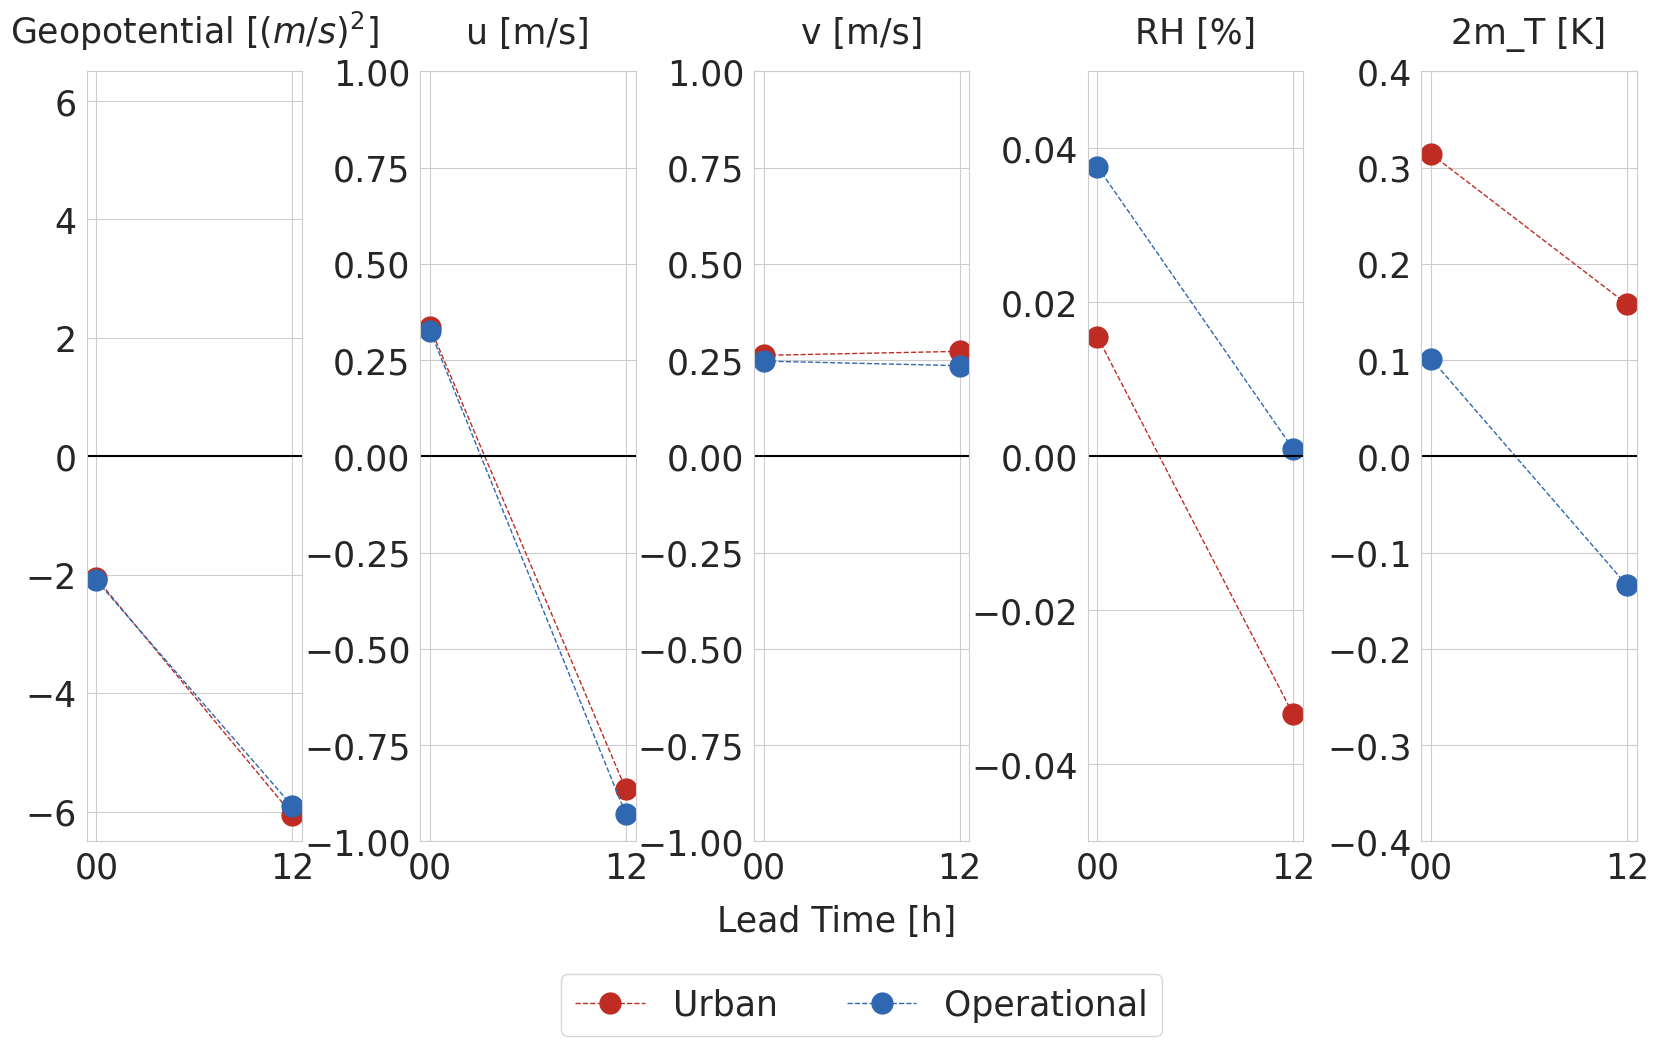

In [181]:
#plot synop stations - measurements global

params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

x = np.unique(urb_12_synop.varno)
varno = ['Geopotential [$(m/s)^2$]', 'u [m/s]', 'v [m/s]', 'RH [%]', '2m_T [K]']

# xlim_start = [-10, -10, -10, 5, 4]
# xlim_end = [10, 10, 10, 5, 4]


xlim_start = [-6.5, -1, -1, -.05, -.4]
xlim_end = [6.5, 1, 1, .05, .4]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10))

dataset = {
    'operational_00h': opr_00_synop_cities,
    'urban_00h': urb_00_synop_cities,
    'operational_12h': opr_12_synop_cities,
    'urban_12h': urb_12_synop_cities,}

for i, x_value in enumerate(x):
    urb_00_data = (dataset['urban_00h'].veri_data[6, :].where(dataset['urban_00h'].varno == x_value).mean() -
                   dataset['urban_00h'].obs.where(dataset['urban_00h'].varno == x_value).mean())
    urb_12_data = (dataset['urban_12h'].veri_data[5, :].where(dataset['urban_12h'].varno == x_value).mean() -
                   dataset['urban_12h'].obs.where(dataset['urban_12h'].varno == x_value).mean())

    opr_00_data = (dataset['operational_00h'].veri_data[6, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())
    opr_12_data = (dataset['operational_12h'].veri_data[5, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    opr_00_3hlt = (dataset['operational_00h'].veri_data[0, :].where(dataset['operational_00h'].varno == x_value).mean() -
                  dataset['operational_00h'].obs.where(dataset['operational_00h'].varno == x_value).mean())

    opr_12_3hlt = (dataset['operational_12h'].veri_data[0, :].where(dataset['operational_12h'].varno == x_value).mean() -
                  dataset['operational_12h'].obs.where(dataset['operational_12h'].varno == x_value).mean())

    ax[i].plot([1, 2], [urb_00_data, urb_12_data], marker='o', markersize = 15, color='#BF2C23', linestyle='--', linewidth=1, label='Urban')
    ax[i].plot([1, 2], [opr_00_data, opr_12_data], marker='o', markersize = 15, color='#2F67B1', linestyle='--', linewidth=1, label='Operational')

    ax[i].set_title(varno[i], pad = 20)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(['00', '12'])
    ax[i].grid(True)
    ax[i].axhline(y=0, color='black', linestyle='-')


ax[-1].legend(loc='upper center', bbox_to_anchor=(-2.6, -0.15), ncol=2)

for i, x_value in enumerate(x):
    ax[i].set_ylim(xlim_start[i], xlim_end[i])

fig.text(0.5, 0.02, 'Lead Time [h]', ha='center', fontsize=25)
fig.subplots_adjust(wspace=0.55) 


plt.savefig('../plots_2024/verification/verification_cities_SYNOP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


In [58]:
#define K-D tree for the TEMP 00 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061500TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [59]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [60]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [61]:
urb_00_temp_cities = urb_00_temp.isel(d_body=indices_cities_ens)
opr_00_temp_cities = opr_00_temp.isel(d_body=indices_cities_ens)

In [62]:
#define K-D tree for the TEMP 12 data

class model_kdtree(object):
    def __init__(self):
        model_ds = xr.open_dataset('../pickle_files/testurban_run2022061512TEMP.nc')
        self.model_ds = model_ds
        self.kdtree = {}
        self.kdtree = KDTree(np.asarray([self.model_ds.lat.values.flatten(),
                                         self.model_ds.lon.values.flatten()]).T)
    
    def query(self, lat_az0, lon_az0):
        distances, indices1d = self.kdtree.query(np.asarray([lat_az0, lon_az0]).T)
        return indices1d

In [63]:
#initialize 
tree_icon = model_kdtree()
tree_icon.kdtree

In [64]:
indices_cities_ens = tree_icon.query(np.asarray(ds_det.clat.values), np.asarray(ds_det.clon.values))

In [65]:
urb_12_temp_cities = urb_12_temp.isel(d_body=indices_cities_ens)
opr_12_temp_cities = opr_12_temp.isel(d_body=indices_cities_ens)

/tmp/ipykernel_2347203/1578489869.py:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


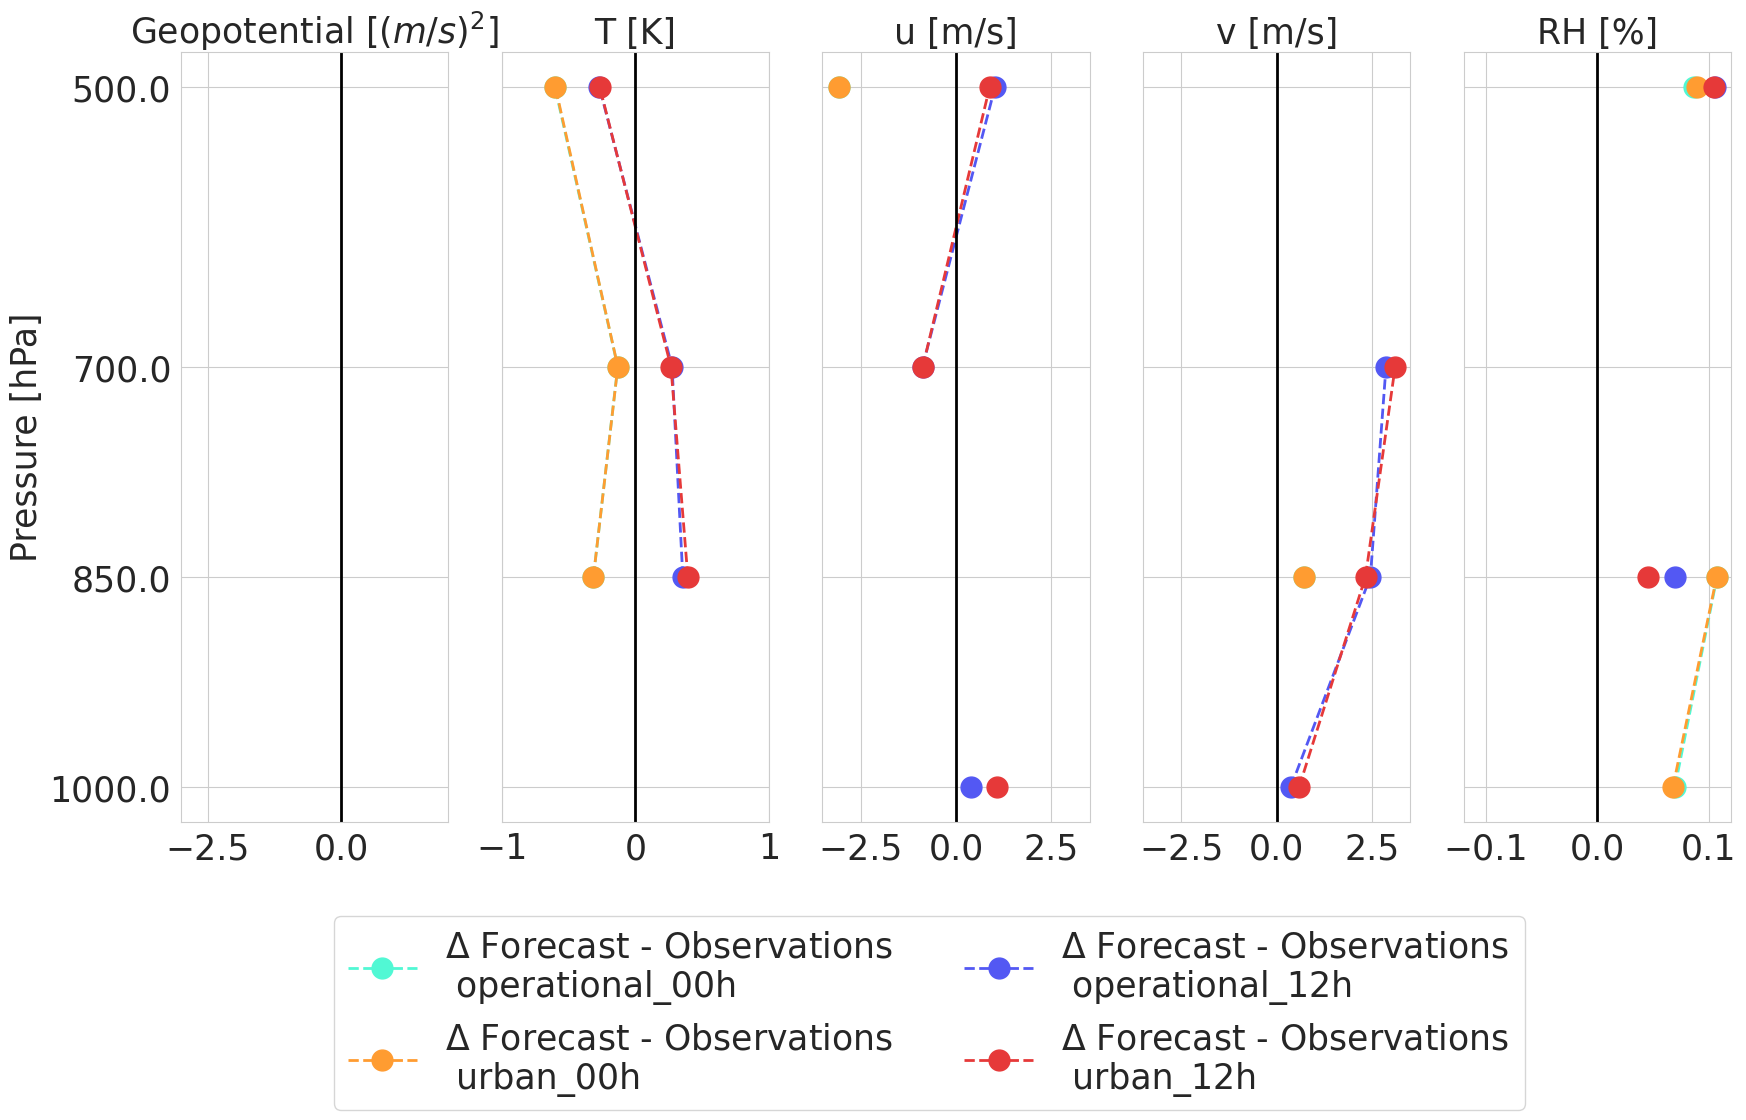

In [168]:
params = {'axes.labelsize': 25,'axes.titlesize':25, 'legend.fontsize': 25, 'xtick.labelsize': 25, 
          'ytick.labelsize': 25}

plt.rcParams.update(params)

p_levels = [100000, 85000, 70000, 50000]
x = np.unique(opr_00_temp.varno)
varno = ['Geopotential [$(m/s)^2$]', 'T [K]', 'u [m/s]', 'v [m/s]', 'RH [%]']

# Define four distinct colors forming two pairs
colors = ['#51F8D4', '#FF9C31', '#5358F3', '#E63939']

xlim_start = [-3, -1, -3.5, -3.5, -.12]
xlim_end = [2, 1, 3.5, 3.5, .12]

fig, ax = plt.subplots(1, len(x), figsize=(20, 10), sharey=True)

datasets_00 = {
    'operational_00h': opr_00_temp_cities,
    'urban_00h': urb_00_temp_cities,
}

datasets_12 = {
    'operational_12h': opr_12_temp_cities,
    'urban_12h': urb_12_temp_cities,
}

for i, x_value in enumerate(x):
    for j, (label, data) in enumerate(datasets_00.items()):
        diff_data = [data.veri_data[6, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15, linestyle='--', linewidth =2,  label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j])

    for j, (label, data) in enumerate(datasets_12.items()):
        diff_data = [data.veri_data[5, :].where((data.plevel == p) & (data.varno == x_value)).mean() - data.obs.where((data.plevel == p) & (data.varno == x_value)).mean() for p in p_levels]
        ax[i].plot(diff_data, p_levels, marker='o', markersize = 15,  linestyle='--', linewidth = 2, label=f'$\Delta$ Forecast - Observations \n {label}', color=colors[j+2])

    ax[i].set_title(varno[i])
    ax[i].set_yticks(p_levels)
    ax[i].set_yticklabels([f'{p / 100}' for p in p_levels])

    # Add vertical line at x = 0
    ax[i].axvline(0, color='black', linewidth=2)

for i, x_value in enumerate(x):
    ax[i].set_xlim(xlim_start[i], xlim_end[i])

ax[0].set_ylabel('Pressure [hPa]')

ax[-1].legend(loc='upper center', bbox_to_anchor=(-2, -.1), ncol=2)

plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('../plots_2024/verification/verification_cities_TEMP_2022.jpeg', dpi=300, bbox_inches='tight')

plt.show()


### RMSE analysis

In [130]:
#RMSE on temperature at 1000 hPa, TEMP

variables_00_urb = [urb_00_temp, urb_00_temp_europe, urb_00_temp_cities]
variables_12_urb = [urb_12_temp, urb_12_temp_europe, urb_12_temp_cities]

variables_00_opr = [opr_00_temp, opr_00_temp_europe, opr_00_temp_cities]
variables_12_opr = [opr_12_temp, opr_12_temp_europe, opr_12_temp_cities]

rmse_urb_00_temp_T = []
rmse_urb_12_temp_T = []
rmse_opr_00_temp_T = []
rmse_opr_12_temp_T = []

for data in variables_00_urb:
    rmse_value = rmse(data.veri_data[6, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_urb_00_temp_T.append(rmse_value.values)

for data in variables_12_urb:
    rmse_value = rmse(data.veri_data[5, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_urb_12_temp_T.append(rmse_value.values)

for data in variables_00_opr:
    rmse_value = rmse(data.veri_data[6, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_opr_00_temp_T.append(rmse_value.values)

for data in variables_12_opr:
    rmse_value = rmse(data.veri_data[5, :].where((data.plevel == 100000) & (data.varno == 2)).mean(), 
                      data.obs.where((data.plevel == 100000) & (data.varno == 2)).mean())
    rmse_opr_12_temp_T.append(rmse_value.values)

In [131]:
print('RSME OPR 00 global:', np.round(rmse_opr_00_temp_T[0], 3),
      'RMSE URB 00 global:', np.round(rmse_urb_00_temp_T[0], 3),
      'RSME OPR 12 global:', np.round(rmse_opr_12_temp_T[0], 3),
      'RSME URB 12 global:', np.round(rmse_urb_12_temp_T[0], 3))

print('RSME OPR 00 europe:', np.round(rmse_opr_00_temp_T[1], 3),
      'RMSE URB 00 europe:', np.round(rmse_urb_00_temp_T[1], 3),
      'RSME OPR 12 europe:', np.round(rmse_opr_12_temp_T[1], 3),
      'RSME URB 12 europe:', np.round(rmse_urb_12_temp_T[1], 3))

print('RSME OPR 00 cities:', np.round(rmse_opr_00_temp_T[2], 3),
      'RMSE URB 00 cities:', np.round(rmse_urb_00_temp_T[2], 3),
      'RSME OPR 12 cities:', np.round(rmse_opr_12_temp_T[2], 3),
      'RSME URB 12 cities:', np.round(rmse_urb_12_temp_T[2], 3))


RSME OPR 00 global: 0.013 RMSE URB 00 global: 0.006 RSME OPR 12 global: 0.144 RSME URB 12 global: 0.103
RSME OPR 00 europe: 0.234 RMSE URB 00 europe: 0.215 RSME OPR 12 europe: 0.12 RSME URB 12 europe: 0.103
RSME OPR 00 cities: nan RMSE URB 00 cities: nan RSME OPR 12 cities: nan RSME URB 12 cities: nan


In [139]:
#RMSE on temperature at 1000 hPa, SNYOP

variables_00_urb = [urb_00_synop, urb_00_synop_europe, urb_00_synop_cities]
variables_12_urb = [urb_12_synop, urb_12_synop_europe, urb_12_synop_cities]

variables_00_opr = [opr_00_synop, opr_00_synop_europe, opr_00_synop_cities]
variables_12_opr = [opr_12_synop, opr_12_synop_europe, opr_12_synop_cities]

rmse_urb_00_synop_2mT = []
rmse_urb_12_synop_2mT = []
rmse_opr_00_synop_2mT = []
rmse_opr_12_synop_2mT = []

for data in variables_00_urb:
    rmse_value = rmse(data.veri_data[6, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_urb_00_synop_2mT.append(rmse_value.values)

for data in variables_12_urb:
    rmse(data.veri_data[5, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_urb_12_synop_2mT.append(rmse_value.values)

for data in variables_00_opr:
    rmse_value = rmse(data.veri_data[6, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_opr_00_synop_2mT.append(rmse_value.values)

for data in variables_12_opr:
    rmse_value = rmse(data.veri_data[5, :].where(data.varno == 39).mean() , 
                      data.obs.where(data.varno == 39).mean())
    rmse_opr_12_synop_2mT.append(rmse_value.values)

In [140]:
print('RSME OPR 00 global:', np.round(rmse_opr_00_synop_2mT[0], 3),
      'RMSE URB 00 global:', np.round(rmse_urb_00_synop_2mT[0], 3),
      'RSME OPR 12 global:', np.round(rmse_opr_12_synop_2mT[0], 3),
      'RSME URB 12 global:', np.round(rmse_urb_12_synop_2mT[0], 3))

print('RSME OPR 00 europe:', np.round(rmse_opr_00_synop_2mT[1], 3),
      'RMSE URB 00 europe:', np.round(rmse_urb_00_synop_2mT[1], 3),
      'RSME OPR 12 europe:', np.round(rmse_opr_12_synop_2mT[1], 3),
      'RSME URB 12 europe:', np.round(rmse_urb_12_synop_2mT[1], 3))

print('RSME OPR 00 cities:', np.round(rmse_opr_00_synop_2mT[2], 3),
      'RMSE URB 00 cities:', np.round(rmse_urb_00_synop_2mT[2], 3),
      'RSME OPR 12 cities:', np.round(rmse_opr_12_synop_2mT[2], 3),
      'RSME URB 12 cities:', np.round(rmse_urb_12_synop_2mT[2], 3))


RSME OPR 00 global: 0.021 RMSE URB 00 global: 0.041 RSME OPR 12 global: 0.125 RSME URB 12 global: 0.314
RSME OPR 00 europe: 0.031 RMSE URB 00 europe: 0.062 RSME OPR 12 europe: 0.21 RSME URB 12 europe: 0.314
RSME OPR 00 cities: 0.101 RMSE URB 00 cities: 0.314 RSME OPR 12 cities: 0.134 RSME URB 12 cities: 0.314


In [229]:
(1 - rmse_urb_12_temp_T[0]/rmse_opr_12_temp_T[0]) * 100

28.82215976715088